# Triplet Loss with Faces -- Fairness Study

## Initialization

In [1]:
# !pip install torch

In [2]:
# !pip install mat73

In [3]:
# !pip install wandb -qqq
# import wandb

In [4]:
# !git clone https://github.com/mgornet/CNPEN

### Check device

In [5]:
!nvidia-smi

Tue Nov 22 13:06:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.85.02    Driver Version: 510.85.02    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A400...  Off  | 00000000:01:00.0  On |                  N/A |
| N/A   59C    P8    21W /  N/A |    545MiB /  8192MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Import Librairies

In [6]:
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from time import perf_counter
from typing import Callable
import itertools
import mat73
import pandas as pd
import re

import sys
import os
import tarfile

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

import os.path as op
try:
    from urllib.request import urlretrieve
except ImportError:  # Python 2 compat
    from urllib import urlretrieve
    
from sklearn.metrics import confusion_matrix, auc, roc_curve, \
precision_recall_curve, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from scipy import optimize

import wandb

In [7]:
%cd ./files/

from triplet import TripletGenerator, TripletLearner, TripletLoss, TripletLossRaw, \
distance, distance_vectors
from builder import create_dataframe, from_tensor_to_numpy, from_numpy_to_tensor, extend_dataframe
from prints import print_img, print_img_from_path, print_img_from_id, \
print_img_from_classid, print_from_gen, print_from_gen2, print_pair, print_hist_loss, \
print_hist_dist, print_hist_dist_zoom, print_img_category, \
print_roc, print_logistic_regression, print_prec_recall
from test_train_loops import training, testing, adaptative_train, compute_distances
from classification import authentification_img, predict, triplet_acc,\
build_df_fairness, triplet_acc_fairness, bootstrap, bootstrap_by_pairs, build_threshold #triplet_acc_for_bootstrap

/home/mgornet/Bureau/Code/CNPEN/files


In [8]:
!pwd

/home/mgornet/Bureau/Code/CNPEN/files


In [9]:
study = 'sampling'
if study not in ['sampling','augmentation', 'normalization', 'depth', 'margin', 'lr', 'threshold']:
    print("The study name is incorrect, please select between: sampling, normalization, augmentation, depth, margin, lr, threshold")

In [10]:
seed = 121
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
print ('Seeds set for fairness phase')

Seeds set for fairness phase


## Generate Data

### Create dataframe

In [11]:
URL = "http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz"
FILENAME = "lfw-deepfunneled.tgz"

if not op.exists(FILENAME):
    print('Downloading %s to %s...' % (URL, FILENAME))
    urlretrieve(URL, FILENAME)

if not op.exists("lfw"):
    print('Extracting image files...')
    tar = tarfile.open("lfw-deepfunneled.tgz")
    tar.extractall("lfw")
    tar.close()

In [12]:
PATH = "lfw/lfw-deepfunneled/"

In [13]:
tic = perf_counter()
df_init, all_imgs = create_dataframe()
toc = perf_counter()
print(f"DataFrame creation: {((toc - tic)/60):.1f} min")

Number of individuals:  5749
Number of total images:  13233
images weigh  0.57 GB
DataFrame creation: 1.3 min


In [14]:
tic = perf_counter()
df = extend_dataframe(df_init)
toc = perf_counter()
print(f"DataFrame extention: {((toc - tic)/60):.1f} min")

DataFrame extention: 0.1 min


### Build sets, generators and network

In [15]:
num_classes = len(df.Classid.unique())
print("Number of individuals: ", num_classes)

Number of individuals:  5749


In [16]:
indiv_min = df.Classid.min()
split_train_valid = int(num_classes * 0.75)
split_train_test = int(num_classes * 0.8)
indiv_max = df.Classid.max()

In [17]:
df_train = df[df.Classid<split_train_valid]
df_valid = df[(df.Classid>=split_train_valid)]#&(df.Classid<split_train_test)]
# df_test = df[df.Classid>=split_train_test]
df_test = df_valid

In [18]:
BATCH_SIZE = 128 # 128
BATCH_VALID_SIZE = 59 #128 #8
BATCH_TEST_SIZE = 59 #128 #32

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
margin = 0.2
# criterion = TripletLoss(margin)
# criterion_test = TripletLossRaw(margin)

### Load Model

In [20]:
# Load pretrained model

model = TripletLearner(base_channels=32)
model.load_state_dict(torch.load("../models/in_article/base_600.pth",map_location=torch.device('cpu'))) #../models/in_article/base_model
model = model.to(device)
model.eval()

gen = TripletGenerator(df_test, all_imgs, BATCH_TEST_SIZE, device, model, margin, return_id=True)
threshold  = build_threshold(df_valid, all_imgs, device, model, margin, BATCH_VALID_SIZE, True)
# threshold = 0.81
tic = perf_counter()
df_fairness = build_df_fairness(all_imgs, df_test, gen, 100, device, model, threshold) #20
toc = perf_counter()
print(f"DataFrame creation for base model: {((toc - tic)/60):.1f} min")

Processing:   0%|          | 0/70 [00:00<?, ?it/s]

Threshold with logistic regression: 0.8188939470098427


Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

DataFrame creation for base model: 0.9 min


### Look at general stats

In [21]:
print("Same identity - mean distance: ", df_fairness[df_fairness.y_true==1].Distance.mean())
print("Same identity - std distance: ", df_fairness[df_fairness.y_true==1].Distance.std())
print("Same identity - percentiles: ", np.percentile(df_fairness[df_fairness.y_true==1]['Distance'], [5,25,50,75,95]))
print("\n")
print("Different identities - mean distance: ", df_fairness[df_fairness.y_true==0].Distance.mean())
print("Different identities - std distance: ", df_fairness[df_fairness.y_true==0].Distance.std())
print("Different identities - percentiles: ", np.percentile(df_fairness[df_fairness.y_true==0]['Distance'], [5,25,50,75,95]))
print("\n")
print("Mean accuracy: ", df_fairness['correct_predict'].mean())
print("Bootstrapping mean accuracy: ", bootstrap(df_fairness, agg_func=lambda df: df['correct_predict'].mean()))
print("\n")
print("Triplet accuracy: ", triplet_acc_fairness(df_fairness))

Same identity - mean distance:  0.41062342889921527
Same identity - std distance:  0.3182634921076271
Same identity - percentiles:  [0.07538106 0.18372968 0.32657677 0.54138064 1.07304049]


Different identities - mean distance:  1.7830244032719305
Different identities - std distance:  1.046626464909062
Different identities - percentiles:  [0.43529592 1.00918069 1.58684838 2.35388315 3.79953626]


Mean accuracy:  0.8680629539951574
Bootstrapping mean accuracy:  [0.86610169 0.8672155  0.86801453 0.86881356 0.86991525]


Triplet accuracy:  0.936319612590799


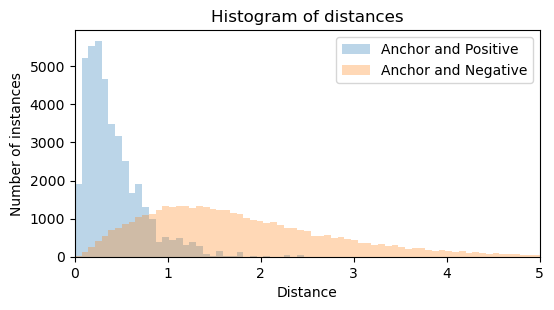

In [22]:
pos_dist = df_fairness[df_fairness.y_true==1]['Distance']
neg_dist = df_fairness[df_fairness.y_true==0]['Distance']
print_hist_dist_zoom(pos_dist, neg_dist, zoom=5.)

In [23]:
X = -np.array(df_fairness.Distance)
y = np.array(df_fairness.y_true)
y_pred = np.array(df_fairness.y_pred)

In [24]:
fpr_dist, tpr_dist, thresholds_dist = roc_curve(y, X)
roc_auc_dist = auc(fpr_dist,tpr_dist)

precision_dist, recall_dist, thresholds_recall_dist = precision_recall_curve(y, X)
auc_s_dist = auc(recall_dist, precision_dist)

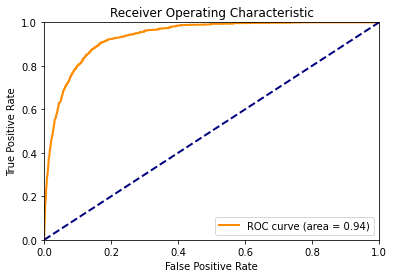

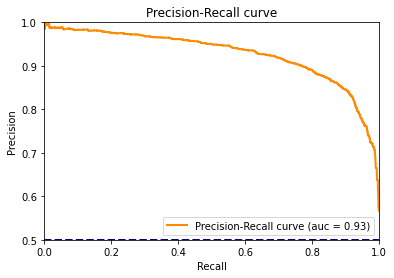

In [25]:
print_roc(fpr_dist, tpr_dist, roc_auc_dist)
print_prec_recall(precision_dist, recall_dist, auc_s_dist)

In [26]:
tn,fp,fn,tp = confusion_matrix(y, y_pred).ravel()

TPR = tp/(tp+fp)
FPR = fp/(tp+fp)
TNR = tn/(tn+fn)
FNR = fn/(tn+fn)

In [27]:
print("Confusion Matrix Total")
print(confusion_matrix(y, y_pred))

print("\n","Accuracy score:",accuracy_score(y, y_pred))
 
print("\n", "f1 score:", f1_score(y, y_pred), "\n")

print('TPR: ', TPR)
print('FPR: ', FPR)
print('TNR: ', TNR)
print('FNR: ', FNR)

Confusion Matrix Total
[[34214  7086]
 [ 3812 37488]]

 Accuracy score: 0.8680629539951574

 f1 score: 0.8730931364557375 

TPR:  0.8410284022075649
FPR:  0.15897159779243505
TNR:  0.8997528007153001
FNR:  0.10024719928469994


### Stats in subgroups

In [ ]:
if study == 'sampling':
    
    model_randomsample = TripletLearner(base_channels=32)
    model_randomsample.load_state_dict(torch.load("../models/in_article/random_sample_600.pth",map_location=torch.device('cpu')))
    model_randomsample = model_randomsample.to(device)
    model_randomsample.eval()
    
    gen_randomsample = TripletGenerator(df_test, all_imgs, BATCH_TEST_SIZE, device, model_randomsample, 0.2, return_id=True)
    threshold_randomsample  = build_threshold(df_valid, all_imgs, device, model_randomsample, 0.2, BATCH_VALID_SIZE, True)
    tic = perf_counter()
    df_fairness_randomsample = build_df_fairness(all_imgs, df_test, gen_randomsample, 20, device, model_randomsample, threshold_randomsample)
    toc = perf_counter()
    print(f"DataFrame creation for model random sampling: {((toc - tic)/60):.1f} min")

elif study == 'normalization':
    
    model_normalized = TripletLearner(base_channels=32)
    model_normalized.load_state_dict(torch.load("../models/in_article/normalized_600.pth",map_location=torch.device('cpu')))
    model_normalized = model_normalized.to(device)
    model_normalized.eval()
    
    gen_normalized = TripletGenerator(df_test, all_imgs, BATCH_TEST_SIZE, device, model_normalized, 0.2, return_id=True)
    threshold_normalized  = build_threshold(df_valid, all_imgs, device, model_normalized, 0.2, BATCH_VALID_SIZE, True)
    tic = perf_counter()
    df_fairness_normalized = build_df_fairness(all_imgs, df_test, gen_normalized, 20, device, model_normalized, threshold_normalized)
    toc = perf_counter()
    print(f"DataFrame creation for model random sampling: {((toc - tic)/60):.1f} min")
    
elif study == 'augmentation':
    model_no_augment = TripletLearner(base_channels=32)
    model_no_augment.load_state_dict(torch.load("../models/in_article/no_augment_600.pth",map_location=torch.device('cpu')))
    model_no_augment = model_no_augment.to(device)
    model_no_augment.eval()
    
    gen_no_augment = TripletGenerator(df_test, all_imgs, BATCH_TEST_SIZE, device, model_no_augment, 0.2, return_id=True)
    threshold_no_augment  = build_threshold(df_valid, all_imgs, device, model_no_augment, 0.2, BATCH_VALID_SIZE, True)
    tic = perf_counter()
    df_fairness_no_augment = build_df_fairness(all_imgs, df_test, gen_no_augment, 20, device, model_no_augment, threshold_no_augment)
    toc = perf_counter()
    print(f"DataFrame creation for model no augmentation: {((toc - tic)/60):.1f} min")
    
    model_high_zoom = TripletLearner(base_channels=32)
    model_high_zoom.load_state_dict(torch.load("../models/in_article/high_zoom_600.pth",map_location=torch.device('cpu')))
    model_high_zoom = model_high_zoom.to(device)
    model_high_zoom.eval()
    
    gen_high_zoom = TripletGenerator(df_test, all_imgs, BATCH_TEST_SIZE, device, model_high_zoom, 0.2, return_id=True)
    threshold_high_zoom  = build_threshold(df_valid, all_imgs, device, model_high_zoom, 0.2, BATCH_VALID_SIZE, True)
    tic = perf_counter()
    df_fairness_high_zoom = build_df_fairness(all_imgs, df_test, gen_high_zoom, 20, device, model_high_zoom, threshold_high_zoom)
    toc = perf_counter()
    print(f"DataFrame creation for model high zoom: {((toc - tic)/60):.1f} min")
    
    model_deformation_double = TripletLearner(base_channels=32)
    model_deformation_double.load_state_dict(torch.load("../models/in_article/deformation_double_600.pth",map_location=torch.device('cpu')))
    model_deformation_double = model_deformation_double.to(device)
    model_deformation_double.eval()
    
    gen_deformation_double = TripletGenerator(df_test, all_imgs, BATCH_TEST_SIZE, device, model_deformation_double, 0.2, return_id=True)
    threshold_deformation_double  = build_threshold(df_valid, all_imgs, device, model_deformation_double, 0.2, BATCH_VALID_SIZE, True)
    tic = perf_counter()
    df_fairness_deformation_double = build_df_fairness(all_imgs, df_test, gen_deformation_double, 20, device, model_deformation_double, threshold_deformation_double)
    toc = perf_counter()
    print(f"DataFrame creation for model high deformation: {((toc - tic)/60):.1f} min")
    
    model_jitter_double = TripletLearner(base_channels=32)
    model_jitter_double.load_state_dict(torch.load("../models/in_article/jitter_double_600.pth",map_location=torch.device('cpu')))
    model_jitter_double = model_jitter_double.to(device)
    model_jitter_double.eval()
    
    gen_jitter_double = TripletGenerator(df_test, all_imgs, BATCH_TEST_SIZE, device, model_jitter_double, 0.2, return_id=True)
    threshold_jitter_double  = build_threshold(df_valid, all_imgs, device, model_jitter_double, 0.2, BATCH_VALID_SIZE, True)
    tic = perf_counter()
    df_fairness_jitter_double = build_df_fairness(all_imgs, df_test, gen_jitter_double, 20, device, model_jitter_double, threshold_jitter_double)
    toc = perf_counter()
    print(f"DataFrame creation for model high color jitter: {((toc - tic)/60):.1f} min")
    
    model_high_rotation = TripletLearner(base_channels=32)
    model_high_rotation.load_state_dict(torch.load("../models/in_article/high_rotation_600.pth",map_location=torch.device('cpu')))
    model_high_rotation = model_high_rotation.to(device)
    model_high_rotation.eval()
    
    gen_high_rotation = TripletGenerator(df_test, all_imgs, BATCH_TEST_SIZE, device, model_high_rotation, 0.2, return_id=True)
    threshold_high_rotation  = build_threshold(df_valid, all_imgs, device, model_high_rotation, 0.2, BATCH_VALID_SIZE, True)
    tic = perf_counter()
    df_fairness_high_rotation = build_df_fairness(all_imgs, df_test, gen_high_rotation, 20, device, model_high_rotation, threshold_high_rotation)
    toc = perf_counter()
    print(f"DataFrame creation for model high rotation: {((toc - tic)/60):.1f} min")
    
    
elif study == 'depth':
    model_depth16 = TripletLearner(base_channels=16)
    model_depth16.load_state_dict(torch.load("../models/in_article/depth16_600.pth",map_location=torch.device('cpu')))
    model_depth16 = model_depth16.to(device)
    model_depth16.eval()
    
    gen_depth16 = TripletGenerator(df_test, all_imgs, BATCH_TEST_SIZE, device, model_depth16, 0.2, return_id=True)
    threshold_depth16  = build_threshold(df_valid, all_imgs, device, model_depth16, 0.2, BATCH_VALID_SIZE, True)
    tic = perf_counter()
    df_fairness_depth16 = build_df_fairness(all_imgs, df_test, gen_depth16, 20, device, model_depth16, threshold_depth16)
    toc = perf_counter()
    print(f"DataFrame creation for model depth 16: {((toc - tic)/60):.1f} min")
    
    model_depth64 = TripletLearner(base_channels=64)
    model_depth64.load_state_dict(torch.load("../models/in_article/depth64_600.pth",map_location=torch.device('cpu')))
    model_depth64 = model_depth64.to(device)
    model_depth64.eval()
    
    gen_depth64 = TripletGenerator(df_test, all_imgs, BATCH_TEST_SIZE, device, model_depth64, 0.2, return_id=True)
    threshold_depth64  = build_threshold(df_valid, all_imgs, device, model_depth64, 0.2, BATCH_VALID_SIZE, True)
    tic = perf_counter()
    df_fairness_depth64 = build_df_fairness(all_imgs, df_test, gen_depth64, 20, device, model_depth64, threshold_depth64)
    toc = perf_counter()
    print(f"DataFrame creation for model depth 64: {((toc - tic)/60):.1f} min")

elif study == 'margin':
    
    model_margin01 = TripletLearner(base_channels=32)
    model_margin01.load_state_dict(torch.load("../models/in_article/margin01_600.pth",map_location=torch.device('cpu')))
    model_margin01 = model_margin01.to(device)
    model_margin01.eval()
    
    gen_margin01 = TripletGenerator(df_test, all_imgs, BATCH_TEST_SIZE, device, model_margin01, 0.1, return_id=True)
    threshold_margin01  = build_threshold(df_valid, all_imgs, device, model_margin01, 0.1, BATCH_VALID_SIZE, True)
    tic = perf_counter()
    df_fairness_margin01 = build_df_fairness(all_imgs, df_test, gen_margin01, 20, device, model_margin01, threshold_margin01)
    toc = perf_counter()
    print(f"DataFrame creation for model margin 0.1: {((toc - tic)/60):.1f} min")
    
    model_margin05 = TripletLearner(base_channels=32)
    model_margin05.load_state_dict(torch.load("../models/in_article/margin05_600.pth",map_location=torch.device('cpu')))
    model_margin05 = model_margin05.to(device)
    model_margin05.eval()
    
    gen_margin05 = TripletGenerator(df_test, all_imgs, BATCH_TEST_SIZE, device, model_margin05, 0.5, return_id=True)
    threshold_margin05  = build_threshold(df_valid, all_imgs, device, model_margin05, 0.5, BATCH_VALID_SIZE, True)
    tic = perf_counter()
    df_fairness_margin05 = build_df_fairness(all_imgs, df_test, gen_margin05, 20, device, model_margin05, threshold_margin05)
    toc = perf_counter()
    print(f"DataFrame creation for model margin 0.5: {((toc - tic)/60):.1f} min")

    model_margin1 = TripletLearner(base_channels=32)
    model_margin1.load_state_dict(torch.load("../models/in_article/margin1_600.pth",map_location=torch.device('cpu')))
    model_margin1 = model_margin1.to(device)
    model_margin1.eval()
    
    gen_margin1 = TripletGenerator(df_test, all_imgs, BATCH_TEST_SIZE, device, model_margin1, 1., return_id=True)
    threshold_margin1  = build_threshold(df_valid, all_imgs, device, model_margin1, 1., BATCH_VALID_SIZE, True)
    tic = perf_counter()
    df_fairness_margin1 = build_df_fairness(all_imgs, df_test, gen_margin1, 20, device, model_margin1, threshold_margin1)
    toc = perf_counter()
    print(f"DataFrame creation for model margin 1: {((toc - tic)/60):.1f} min")
    
elif study == 'lr':
    model_lr3 = TripletLearner(base_channels=32)
    model_lr3.load_state_dict(torch.load("../models/in_article/lr3_600.pth",map_location=torch.device('cpu')))
    model_lr3 = model_lr3.to(device)
    model_lr3.eval()
    
    gen_lr3 = TripletGenerator(df_test, all_imgs, BATCH_TEST_SIZE, device, model_lr3, 0.2, return_id=True)
    threshold_lr3  = build_threshold(df_valid, all_imgs, device, model_lr3, 0.2, BATCH_VALID_SIZE, True)
    tic = perf_counter()
    df_fairness_lr3 = build_df_fairness(all_imgs, df_test, gen_lr3, 20, device, model_lr3, threshold_lr3)
    toc = perf_counter()
    print(f"DataFrame creation for model lr 10-3: {((toc - tic)/60):.1f} min")
    
    model_lr4 = TripletLearner(base_channels=32)
    model_lr4.load_state_dict(torch.load("../models/in_article/lr4_600.pth",map_location=torch.device('cpu')))
    model_lr4 = model_lr4.to(device)
    model_lr4.eval()
    
    gen_lr4 = TripletGenerator(df_test, all_imgs, BATCH_TEST_SIZE, device, model_lr4, 0.2, return_id=True)
    threshold_lr4  = build_threshold(df_valid, all_imgs, device, model_lr4, 0.2, BATCH_VALID_SIZE, True)
    tic = perf_counter()
    df_fairness_lr4 = build_df_fairness(all_imgs, df_test, gen_lr4, 20, device, model_lr4, threshold_lr4)
    toc = perf_counter()
    print(f"DataFrame creation for model lr 10-3: {((toc - tic)/60):.1f} min")
    
    model_lrschedule100 = TripletLearner(base_channels=32)
    model_lrschedule100.load_state_dict(torch.load("../models/in_article/lrschedule100_600.pth",map_location=torch.device('cpu')))
    model_lrschedule100 = model_lrschedule100.to(device)
    model_lrschedule100.eval()
    
    gen_lrschedule100 = TripletGenerator(df_test, all_imgs, BATCH_TEST_SIZE, device, model_lrschedule100, 0.2, return_id=True)
    threshold_lrschedule100  = build_threshold(df_valid, all_imgs, device, model_lrschedule100, 0.2, BATCH_VALID_SIZE, True)
    tic = perf_counter()
    df_fairness_lrschedule100 = build_df_fairness(all_imgs, df_test, gen_lrschedule100, 20, device, model_lrschedule100, threshold_lrschedule100)
    toc = perf_counter()
    print(f"DataFrame creation for model lr 10-3: {((toc - tic)/60):.1f} min")
    
    model_lrschedule300 = TripletLearner(base_channels=32)
    model_lrschedule300.load_state_dict(torch.load("../models/in_article/lrschedule300_600.pth",map_location=torch.device('cpu')))
    model_lrschedule300 = model_lrschedule300.to(device)
    model_lrschedule300.eval()
    
    gen_lrschedule300 = TripletGenerator(df_test, all_imgs, BATCH_TEST_SIZE, device, model_lrschedule300, 0.2, return_id=True)
    threshold_lrschedule300  = build_threshold(df_valid, all_imgs, device, model_lrschedule300, 0.2, BATCH_VALID_SIZE, True)
    tic = perf_counter()
    df_fairness_lrschedule300 = build_df_fairness(all_imgs, df_test, gen_lrschedule300, 20, device, model_lrschedule300, threshold_lrschedule300)
    toc = perf_counter()
    print(f"DataFrame creation for model lr 10-3: {((toc - tic)/60):.1f} min")
    
elif study == 'threshold':
    model_lowthrd = TripletLearner(base_channels=32)
    model_lowthrd.load_state_dict(torch.load("../models/in_article/base_600.pth",map_location=torch.device('cpu'))) #../models/in_article/base_model
    model_lowthrd = model_lowthrd.to(device)
    model_lowthrd.eval()

    gen_lowthrd = TripletGenerator(df_test, all_imgs, BATCH_TEST_SIZE, device, model_lowthrd, margin, return_id=True)
    threshold_lowthrd  = 0.48
    tic = perf_counter()
    df_fairness_lowthrd = build_df_fairness(all_imgs, df_test, gen_lowthrd, 20, device, model_lowthrd, threshold_lowthrd) #20
    toc = perf_counter()
    print(f"DataFrame creation for model low threshold: {((toc - tic)/60):.1f} min")
    
    model_highthrd = TripletLearner(base_channels=32)
    model_highthrd.load_state_dict(torch.load("../models/in_article/base_600.pth",map_location=torch.device('cpu'))) #../models/in_article/base_model
    model_highthrd = model_highthrd.to(device)
    model_highthrd.eval()

    gen_highthrd = TripletGenerator(df_test, all_imgs, BATCH_TEST_SIZE, device, model_highthrd, margin, return_id=True)
    threshold_highthrd  = 1.15
    tic = perf_counter()
    df_fairness_highthrd = build_df_fairness(all_imgs, df_test, gen_highthrd, 20, device, model_highthrd, threshold_highthrd) #20
    toc = perf_counter()
    print(f"DataFrame creation for model high threshold: {((toc - tic)/60):.1f} min")

#### White Male vs Non White Male

In [ ]:
pos_dist = df_fairness[(df_fairness.y_true==1) & (df_fairness.AB_WhiteMale==1)]['Distance']
neg_dist = df_fairness[(df_fairness.y_true==0) & (df_fairness.AB_WhiteMale==1)]['Distance']
print_hist_dist_zoom(pos_dist, neg_dist, zoom=5.)

In [ ]:
pos_dist = df_fairness[(df_fairness.y_true==1) & (df_fairness.AB_NoWhiteMale==1)]['Distance']
neg_dist = df_fairness[(df_fairness.y_true==0) & (df_fairness.AB_NoWhiteMale==1)]['Distance']
print_hist_dist_zoom(pos_dist, neg_dist, zoom=5.)

In [ ]:
pos_dist = df_fairness[(df_fairness.y_true==1) & (df_fairness.AB_WhiteMale==0)]['Distance']
neg_dist = df_fairness[(df_fairness.y_true==0) & (df_fairness.AB_WhiteMale==0)]['Distance']
print_hist_dist_zoom(pos_dist, neg_dist, zoom=5.)

In [ ]:
y_AB_WhiteMale = np.array(df_fairness[df_fairness['AB_WhiteMale']==1].y_true)
y_pred_AB_WhiteMale = np.array(df_fairness[df_fairness['AB_WhiteMale']==1].y_pred)

tn_AB_WhiteMale,fp_AB_WhiteMale,fn_AB_WhiteMale,tp_AB_WhiteMale = confusion_matrix(y_AB_WhiteMale, y_pred_AB_WhiteMale).ravel()

TPR_AB_WhiteMale = tp_AB_WhiteMale/(tp_AB_WhiteMale+fp_AB_WhiteMale)
FPR_AB_WhiteMale = fp_AB_WhiteMale/(tp_AB_WhiteMale+fp_AB_WhiteMale)
TNR_AB_WhiteMale = tn_AB_WhiteMale/(tn_AB_WhiteMale+fn_AB_WhiteMale)
FNR_AB_WhiteMale = fn_AB_WhiteMale/(tn_AB_WhiteMale+fn_AB_WhiteMale)

y_AB_NoWhiteMale = np.array(df_fairness[df_fairness['AB_NoWhiteMale']==1].y_true)
y_pred_AB_NoWhiteMale = np.array(df_fairness[df_fairness['AB_NoWhiteMale']==1].y_pred)

tn_AB_NoWhiteMale,fp_AB_NoWhiteMale,fn_AB_NoWhiteMale,tp_AB_NoWhiteMale = confusion_matrix(y_AB_NoWhiteMale, y_pred_AB_NoWhiteMale).ravel()

TPR_AB_NoWhiteMale = tp_AB_NoWhiteMale/(tp_AB_NoWhiteMale+fp_AB_NoWhiteMale)
FPR_AB_NoWhiteMale = fp_AB_NoWhiteMale/(tp_AB_NoWhiteMale+fp_AB_NoWhiteMale)
TNR_AB_NoWhiteMale = tn_AB_NoWhiteMale/(tn_AB_NoWhiteMale+fn_AB_NoWhiteMale)
FNR_AB_NoWhiteMale = fn_AB_NoWhiteMale/(tn_AB_NoWhiteMale+fn_AB_NoWhiteMale)

y_AoB_NoWhiteMale = np.array(df_fairness[df_fairness['AB_WhiteMale']==0].y_true)
y_pred_AoB_NoWhiteMale = np.array(df_fairness[df_fairness['AB_WhiteMale']==0].y_pred)

tn_AoB_NoWhiteMale,fp_AoB_NoWhiteMale,fn_AoB_NoWhiteMale,tp_AoB_NoWhiteMale = confusion_matrix(y_AoB_NoWhiteMale, y_pred_AoB_NoWhiteMale).ravel()

TPR_AoB_NoWhiteMale = tp_AoB_NoWhiteMale/(tp_AoB_NoWhiteMale+fp_AoB_NoWhiteMale)
FPR_AoB_NoWhiteMale = fp_AoB_NoWhiteMale/(tp_AoB_NoWhiteMale+fp_AoB_NoWhiteMale)
TNR_AoB_NoWhiteMale = tn_AoB_NoWhiteMale/(tn_AoB_NoWhiteMale+fn_AoB_NoWhiteMale)
FNR_AoB_NoWhiteMale = fn_AoB_NoWhiteMale/(tn_AoB_NoWhiteMale+fn_AoB_NoWhiteMale)

In [ ]:
print("A and B White Male - mean accuracy: ", df_fairness[df_fairness['AB_WhiteMale']==1]['correct_predict'].mean())
print("A and B White Male - bootstrapping mean accuracy: ", bootstrap(df_fairness[df_fairness['AB_WhiteMale']==1], agg_func=lambda df: df['correct_predict'].mean()))
print("A and B White Male - triplet accuracy: ", triplet_acc_fairness(df_fairness[df_fairness['AB_WhiteMale']==1]))
print("A and B White Male - f1 score:", f1_score(y_AB_WhiteMale, y_pred_AB_WhiteMale))
print("\n")
print("A and B Non White Male - mean accuracy: ", df_fairness[df_fairness['AB_NoWhiteMale']==1]['correct_predict'].mean())
print("A and B Non White Male - bootstrapping mean accuracy: ", bootstrap(df_fairness[df_fairness['AB_NoWhiteMale']==1], agg_func=lambda df: df['correct_predict'].mean()))
print("A and B Non White Male - triplet accuracy: ", triplet_acc_fairness(df_fairness[df_fairness['AB_NoWhiteMale']==1]))
print("A and B Non White Male - f1 score:", f1_score(y_AB_NoWhiteMale, y_pred_AB_NoWhiteMale))
print("\n")
print("A or B Non White Male - mean accuracy: ", df_fairness[df_fairness['AB_WhiteMale']==0]['correct_predict'].mean())
print("A or B Non White Male - bootstrapping mean accuracy: ", bootstrap(df_fairness[df_fairness['AB_WhiteMale']==0], agg_func=lambda df: df['correct_predict'].mean()))
print("A or B Non White Male - triplet accuracy: ", triplet_acc_fairness(df_fairness[df_fairness['AB_WhiteMale']==0]))
print("A or B Non White Male - f1 score:", f1_score(y_AoB_NoWhiteMale, y_pred_AoB_NoWhiteMale))

In [ ]:
print("A and B White Male - Confusion Matrix")
print(confusion_matrix(y_AB_WhiteMale, y_pred_AB_WhiteMale))
print("\n")
print('A and B White Male - TPR: ', TPR_AB_WhiteMale)
print('A and B White Male - FPR: ', FPR_AB_WhiteMale)
print('A and B White Male - TNR: ', TNR_AB_WhiteMale)
print('A and B White Male - FNR: ', FNR_AB_WhiteMale)

In [ ]:
print("A and B Non White Male - Confusion Matrix")
print(confusion_matrix(y_AB_NoWhiteMale, y_pred_AB_NoWhiteMale))
print("\n")
print('A and B Non White Male - TPR: ', TPR_AB_NoWhiteMale)
print('A and B Non White Male - FPR: ', FPR_AB_NoWhiteMale)
print('A and B Non White Male - TNR: ', TNR_AB_NoWhiteMale)
print('A and B Non White Male - FNR: ', FNR_AB_NoWhiteMale)

In [ ]:
print("A or B Non White Male - Confusion Matrix")
print(confusion_matrix(y_AoB_NoWhiteMale, y_pred_AoB_NoWhiteMale))
print("\n")
print('A or B Non White Male - TPR: ', TPR_AoB_NoWhiteMale)
print('A or B Non White Male - FPR: ', FPR_AoB_NoWhiteMale)
print('A or B Non White Male - TNR: ', TNR_AoB_NoWhiteMale)
print('A or B Non White Male - FNR: ', FNR_AoB_NoWhiteMale)

#### Male vs Non Male and White vs Non White

In [ ]:
pos_dist = df_fairness[(df_fairness.y_true==1) & (df_fairness['A_Male']==1)&(df_fairness['B_Male']==1)]['Distance']
neg_dist = df_fairness[(df_fairness.y_true==0) & (df_fairness['A_Male']==1)&(df_fairness['B_Male']==1)]['Distance']
print_hist_dist_zoom(pos_dist, neg_dist, zoom=5.)

In [ ]:
pos_dist = df_fairness[(df_fairness.y_true==1) & (df_fairness['A_Male']==0)&(df_fairness['B_Male']==0)]['Distance']
neg_dist = df_fairness[(df_fairness.y_true==0) & (df_fairness['A_Male']==0)&(df_fairness['B_Male']==0)]['Distance']
print_hist_dist_zoom(pos_dist, neg_dist, zoom=5.)

In [ ]:
pos_dist = df_fairness[(df_fairness.y_true==1) & (df_fairness['A_White']==1)&(df_fairness['B_White']==1)]['Distance']
neg_dist = df_fairness[(df_fairness.y_true==0) & (df_fairness['A_White']==1)&(df_fairness['B_White']==1)]['Distance']
print_hist_dist_zoom(pos_dist, neg_dist, zoom=5.)

In [ ]:
pos_dist = df_fairness[(df_fairness.y_true==1) & (df_fairness['A_White']==0)&(df_fairness['B_White']==0)]['Distance']
neg_dist = df_fairness[(df_fairness.y_true==0) & (df_fairness['A_White']==0)&(df_fairness['B_White']==0)]['Distance']
print_hist_dist_zoom(pos_dist, neg_dist, zoom=5.)

In [ ]:
y_AB_Male = np.array(df_fairness[(df_fairness['A_Male']==1)&(df_fairness['B_Male']==1)].y_true)
y_pred_AB_Male = np.array(df_fairness[(df_fairness['A_Male']==1)&(df_fairness['B_Male']==1)].y_pred)

tn_AB_Male,fp_AB_Male,fn_AB_Male,tp_AB_Male = confusion_matrix(y_AB_Male, y_pred_AB_Male).ravel()

TPR_AB_Male = tp_AB_Male/(tp_AB_Male+fp_AB_Male)
FPR_AB_Male = fp_AB_Male/(tp_AB_Male+fp_AB_Male)
TNR_AB_Male = tn_AB_Male/(tn_AB_Male+fn_AB_Male)
FNR_AB_Male = fn_AB_Male/(tn_AB_Male+fn_AB_Male)

y_AB_NoMale = np.array(df_fairness[(df_fairness['A_Male']==0)&(df_fairness['B_Male']==0)].y_true)
y_pred_AB_NoMale = np.array(df_fairness[(df_fairness['A_Male']==0)&(df_fairness['B_Male']==0)].y_pred)

tn_AB_NoMale,fp_AB_NoMale,fn_AB_NoMale,tp_AB_NoMale = confusion_matrix(y_AB_NoMale, y_pred_AB_NoMale).ravel()

TPR_AB_NoMale = tp_AB_NoMale/(tp_AB_NoMale+fp_AB_NoMale)
FPR_AB_NoMale = fp_AB_NoMale/(tp_AB_NoMale+fp_AB_NoMale)
TNR_AB_NoMale = tn_AB_NoMale/(tn_AB_NoMale+fn_AB_NoMale)
FNR_AB_NoMale = fn_AB_NoMale/(tn_AB_NoMale+fn_AB_NoMale)

In [ ]:
print("A and B Male - mean accuracy: ", df_fairness[(df_fairness['A_Male']==1)&(df_fairness['B_Male']==1)]['correct_predict'].mean())
print("A and B Male - bootstrapping mean accuracy: ", bootstrap(df_fairness[(df_fairness['A_Male']==1)&(df_fairness['B_Male']==1)], agg_func=lambda df: df['correct_predict'].mean()))
print("A and B Male - triplet accuracy: ", triplet_acc_fairness(df_fairness[(df_fairness['A_Male']==1)&(df_fairness['B_Male']==1)]))
print("A and B Male - f1 score:", f1_score(y_AB_Male, y_pred_AB_Male))
print("A and B Male - Confusion Matrix")
print(confusion_matrix(y_AB_Male, y_pred_AB_Male))
print('A and B Male - TPR: ', TPR_AB_Male)
print('A and B Male - FPR: ', FPR_AB_Male)
print('A and B Male - TNR: ', TNR_AB_Male)
print('A and B Male - FNR: ', FNR_AB_Male)
print("\n")
print("A and B Non Male - mean accuracy: ", df_fairness[(df_fairness['A_Male']==0)&(df_fairness['B_Male']==0)]['correct_predict'].mean())
print("A and B Non Male - bootstrapping mean accuracy: ", bootstrap(df_fairness[(df_fairness['A_Male']==0)&(df_fairness['B_Male']==0)], agg_func=lambda df: df['correct_predict'].mean()))
print("A and B Non Male - triplet accuracy: ", triplet_acc_fairness(df_fairness[(df_fairness['A_Male']==0)&(df_fairness['B_Male']==0)]))
print("A and B Non Male - f1 score:", f1_score(y_AB_NoMale, y_pred_AB_NoMale))
print("A and B Non Male - Confusion Matrix")
print(confusion_matrix(y_AB_NoMale, y_pred_AB_NoMale))
print('A and B Non Male - TPR: ', TPR_AB_NoMale)
print('A and B Non Male - FPR: ', FPR_AB_NoMale)
print('A and B Non Male - TNR: ', TNR_AB_NoMale)
print('A and B Non Male - FNR: ', FNR_AB_NoMale)

In [ ]:
y_AB_White = np.array(df_fairness[(df_fairness['A_White']==1)&(df_fairness['B_White']==1)].y_true)
y_pred_AB_White = np.array(df_fairness[(df_fairness['A_White']==1)&(df_fairness['B_White']==1)].y_pred)

tn_AB_White,fp_AB_White,fn_AB_White,tp_AB_White = confusion_matrix(y_AB_White, y_pred_AB_White).ravel()

TPR_AB_White = tp_AB_White/(tp_AB_White+fp_AB_White)
FPR_AB_White = fp_AB_White/(tp_AB_White+fp_AB_White)
TNR_AB_White = tn_AB_White/(tn_AB_White+fn_AB_White)
FNR_AB_White = fn_AB_White/(tn_AB_White+fn_AB_White)

y_AB_NoWhite = np.array(df_fairness[(df_fairness['A_White']==0)&(df_fairness['B_White']==0)].y_true)
y_pred_AB_NoWhite = np.array(df_fairness[(df_fairness['A_White']==0)&(df_fairness['B_White']==0)].y_pred)

tn_AB_NoWhite,fp_AB_NoWhite,fn_AB_NoWhite,tp_AB_NoWhite = confusion_matrix(y_AB_NoWhite, y_pred_AB_NoWhite).ravel()

TPR_AB_NoWhite = tp_AB_NoWhite/(tp_AB_NoWhite+fp_AB_NoWhite)
FPR_AB_NoWhite = fp_AB_NoWhite/(tp_AB_NoWhite+fp_AB_NoWhite)
TNR_AB_NoWhite = tn_AB_NoWhite/(tn_AB_NoWhite+fn_AB_NoWhite)
FNR_AB_NoWhite = fn_AB_NoWhite/(tn_AB_NoWhite+fn_AB_NoWhite)

In [ ]:
print("A and B White - mean accuracy: ", df_fairness[(df_fairness['A_White']==1)&(df_fairness['B_White']==1)]['correct_predict'].mean())
print("A and B White - bootstrapping mean accuracy: ", bootstrap(df_fairness[(df_fairness['A_White']==1)&(df_fairness['B_White']==1)], agg_func=lambda df: df['correct_predict'].mean()))
print("A and B White - triplet accuracy: ", triplet_acc_fairness(df_fairness[(df_fairness['A_White']==1)&(df_fairness['B_White']==1)]))
print("A and B White - f1 score:", f1_score(y_AB_White, y_pred_AB_White))
print("A and B White - Confusion Matrix")
print(confusion_matrix(y_AB_White, y_pred_AB_White))
print('A and B White - TPR: ', TPR_AB_White)
print('A and B White - FPR: ', FPR_AB_White)
print('A and B White - TNR: ', TNR_AB_White)
print('A and B White - FNR: ', FNR_AB_White)
print("\n")
print("A and B Non White - mean accuracy: ", df_fairness[(df_fairness['A_White']==0)&(df_fairness['B_White']==0)]['correct_predict'].mean())
print("A and B Non White - bootstrapping mean accuracy: ", bootstrap(df_fairness[(df_fairness['A_White']==0)&(df_fairness['B_White']==0)], agg_func=lambda df: df['correct_predict'].mean()))
print("A and B Non White - triplet accuracy: ", triplet_acc_fairness(df_fairness[(df_fairness['A_White']==0)&(df_fairness['B_White']==0)]))
print("A and B Non White - f1 score:", f1_score(y_AB_NoWhite, y_pred_AB_NoWhite))
print("A and B Non White - Confusion Matrix")
print(confusion_matrix(y_AB_NoWhite, y_pred_AB_NoWhite))
print('A and B Non White - TPR: ', TPR_AB_NoWhite)
print('A and B Non White - FPR: ', FPR_AB_NoWhite)
print('A and B Non White - TNR: ', TNR_AB_NoWhite)
print('A and B Non White - FNR: ', FNR_AB_NoWhite)

### Other categories

#### Supposed races

In [ ]:
y_AB_Black = np.array(df_fairness[(df_fairness['A_Black']==1)&(df_fairness['B_Black']==1)].y_true)
y_pred_AB_Black = np.array(df_fairness[(df_fairness['A_Black']==1)&(df_fairness['B_Black']==1)].y_pred)

tn_AB_Black,fp_AB_Black,fn_AB_Black,tp_AB_Black = confusion_matrix(y_AB_Black, y_pred_AB_Black).ravel()

TPR_AB_Black = tp_AB_Black/(tp_AB_Black+fp_AB_Black)
FPR_AB_Black = fp_AB_Black/(tp_AB_Black+fp_AB_Black)
TNR_AB_Black = tn_AB_Black/(tn_AB_Black+fn_AB_Black)
FNR_AB_Black = fn_AB_Black/(tn_AB_Black+fn_AB_Black)

y_AB_Asian = np.array(df_fairness[(df_fairness['A_Asian']==1)&(df_fairness['B_Asian']==1)].y_true)
y_pred_AB_Asian = np.array(df_fairness[(df_fairness['A_Asian']==1)&(df_fairness['B_Asian']==1)].y_pred)

tn_AB_Asian,fp_AB_Asian,fn_AB_Asian,tp_AB_Asian = confusion_matrix(y_AB_Asian, y_pred_AB_Asian).ravel()

TPR_AB_Asian = tp_AB_Asian/(tp_AB_Asian+fp_AB_Asian)
FPR_AB_Asian = fp_AB_Asian/(tp_AB_Asian+fp_AB_Asian)
TNR_AB_Asian = tn_AB_Asian/(tn_AB_Asian+fn_AB_Asian)
FNR_AB_Asian = fn_AB_Asian/(tn_AB_Asian+fn_AB_Asian)

y_AB_Indian = np.array(df_fairness[(df_fairness['A_Indian']==1)&(df_fairness['B_Indian']==1)].y_true)
y_pred_AB_Indian = np.array(df_fairness[(df_fairness['A_Indian']==1)&(df_fairness['B_Indian']==1)].y_pred)

tn_AB_Indian,fp_AB_Indian,fn_AB_Indian,tp_AB_Indian = confusion_matrix(y_AB_Indian, y_pred_AB_Indian).ravel()

TPR_AB_Indian = tp_AB_Indian/(tp_AB_Indian+fp_AB_Indian)
FPR_AB_Indian = fp_AB_Indian/(tp_AB_Indian+fp_AB_Indian)
TNR_AB_Indian = tn_AB_Indian/(tn_AB_Indian+fn_AB_Indian)
FNR_AB_Indian = fn_AB_Indian/(tn_AB_Indian+fn_AB_Indian)

In [ ]:
print("A and B White - mean accuracy: ", df_fairness[(df_fairness['A_White']==1)&(df_fairness['B_White']==1)]['correct_predict'].mean())
print("A and B White - bootstrapping mean accuracy: ", bootstrap(df_fairness[(df_fairness['A_White']==1)&(df_fairness['B_White']==1)], agg_func=lambda df: df['correct_predict'].mean()))
print("A and B White - triplet accuracy: ", triplet_acc_fairness(df_fairness[(df_fairness['A_White']==1)&(df_fairness['B_White']==1)]))
print("A and B White - f1 score:", f1_score(y_AB_White, y_pred_AB_White))
print("A and B White - Confusion Matrix")
print(confusion_matrix(y_AB_White, y_pred_AB_White))
print('A and B White - TPR: ', TPR_AB_White)
print('A and B White - FPR: ', FPR_AB_White)
print('A and B White - TNR: ', TNR_AB_White)
print('A and B White - FNR: ', FNR_AB_White)
print("\n")
print("A and B Black - mean accuracy: ", df_fairness[(df_fairness['A_Black']==1)&(df_fairness['B_Black']==1)]['correct_predict'].mean())
print("A and B Black - bootstrapping mean accuracy: ", bootstrap(df_fairness[(df_fairness['A_Black']==1)&(df_fairness['B_Black']==1)], agg_func=lambda df: df['correct_predict'].mean()))
print("A and B Black - triplet accuracy: ", triplet_acc_fairness(df_fairness[(df_fairness['A_Black']==1)&(df_fairness['B_Black']==1)]))
print("A and B Black - f1 score:", f1_score(y_AB_Black, y_pred_AB_Black))
print("A and B Black - Confusion Matrix")
print(confusion_matrix(y_AB_Black, y_pred_AB_Black))
print('A and B Black - TPR: ', TPR_AB_Black)
print('A and B Black - FPR: ', FPR_AB_Black)
print('A and B Black - TNR: ', TNR_AB_Black)
print('A and B Black - FNR: ', FNR_AB_Black)
print("\n")
print("A and B Asian - mean accuracy: ", df_fairness[(df_fairness['A_Asian']==1)&(df_fairness['B_Asian']==1)]['correct_predict'].mean())
print("A and B Asian - bootstrapping mean accuracy: ", bootstrap(df_fairness[(df_fairness['A_Asian']==1)&(df_fairness['B_Asian']==1)], agg_func=lambda df: df['correct_predict'].mean()))
print("A and B Asian - triplet accuracy: ", triplet_acc_fairness(df_fairness[(df_fairness['A_Asian']==1)&(df_fairness['B_Asian']==1)]))
print("A and B Asian - f1 score:", f1_score(y_AB_Asian, y_pred_AB_Asian))
print("A and B Asian - Confusion Matrix")
print(confusion_matrix(y_AB_Asian, y_pred_AB_Asian))
print('A and B Asian - TPR: ', TPR_AB_Asian)
print('A and B Asian - FPR: ', FPR_AB_Asian)
print('A and B Asian - TNR: ', TNR_AB_Asian)
print('A and B Asian - FNR: ', FNR_AB_Asian)
print("\n")
print("A and B Indian - mean accuracy: ", df_fairness[(df_fairness['A_Indian']==1)&(df_fairness['B_Indian']==1)]['correct_predict'].mean())
print("A and B Indian - bootstrapping mean accuracy: ", bootstrap(df_fairness[(df_fairness['A_Indian']==1)&(df_fairness['B_Indian']==1)], agg_func=lambda df: df['correct_predict'].mean()))
print("A and B Indian - triplet accuracy: ", triplet_acc_fairness(df_fairness[(df_fairness['A_Indian']==1)&(df_fairness['B_Indian']==1)]))
print("A and B Indian - f1 score:", f1_score(y_AB_Indian, y_pred_AB_Indian))
print("A and B Indian - Confusion Matrix")
print(confusion_matrix(y_AB_Indian, y_pred_AB_Indian))
print('A and B Indian - TPR: ', TPR_AB_Indian)
print('A and B Indian - FPR: ', FPR_AB_Indian)
print('A and B Indian - TNR: ', TNR_AB_Indian)
print('A and B Indian - FNR: ', FNR_AB_Indian)

#### Youth vs Senior

In [ ]:
y_AB_Youth = np.array(df_fairness[(df_fairness['A_Youth']==1)&(df_fairness['B_Youth']==1)].y_true)
y_pred_AB_Youth = np.array(df_fairness[(df_fairness['A_Youth']==1)&(df_fairness['B_Youth']==1)].y_pred)

tn_AB_Youth,fp_AB_Youth,fn_AB_Youth,tp_AB_Youth = confusion_matrix(y_AB_Youth, y_pred_AB_Youth).ravel()

TPR_AB_Youth = tp_AB_Youth/(tp_AB_Youth+fp_AB_Youth)
FPR_AB_Youth = fp_AB_Youth/(tp_AB_Youth+fp_AB_Youth)
TNR_AB_Youth = tn_AB_Youth/(tn_AB_Youth+fn_AB_Youth)
FNR_AB_Youth = fn_AB_Youth/(tn_AB_Youth+fn_AB_Youth)

y_AB_Senior = np.array(df_fairness[(df_fairness['A_Senior']==1)&(df_fairness['B_Senior']==1)].y_true)
y_pred_AB_Senior = np.array(df_fairness[(df_fairness['A_Senior']==1)&(df_fairness['B_Senior']==1)].y_pred)

tn_AB_Senior,fp_AB_Senior,fn_AB_Senior,tp_AB_Senior = confusion_matrix(y_AB_Senior, y_pred_AB_Senior).ravel()

TPR_AB_Senior = tp_AB_Senior/(tp_AB_Senior+fp_AB_Senior)
FPR_AB_Senior = fp_AB_Senior/(tp_AB_Senior+fp_AB_Senior)
TNR_AB_Senior = tn_AB_Senior/(tn_AB_Senior+fn_AB_Senior)
FNR_AB_Senior = fn_AB_Senior/(tn_AB_Senior+fn_AB_Senior)

In [ ]:
print("A and B Youth - mean accuracy: ", df_fairness[(df_fairness['A_Youth']==1)&(df_fairness['B_Youth']==1)]['correct_predict'].mean())
print("A and B Youth - bootstrapping mean accuracy: ", bootstrap(df_fairness[(df_fairness['A_Youth']==1)&(df_fairness['B_Youth']==1)], agg_func=lambda df: df['correct_predict'].mean()))
print("A and B Youth - triplet accuracy: ", triplet_acc_fairness(df_fairness[(df_fairness['A_Youth']==1)&(df_fairness['B_Youth']==1)]))
print("A and B Youth - f1 score:", f1_score(y_AB_Youth, y_pred_AB_Youth))
print("A and B Youth - Confusion Matrix")
print(confusion_matrix(y_AB_Youth, y_pred_AB_Youth))
print('A and B Youth - TPR: ', TPR_AB_Youth)
print('A and B Youth - FPR: ', FPR_AB_Youth)
print('A and B Youth - TNR: ', TNR_AB_Youth)
print('A and B Youth - FNR: ', FNR_AB_Youth)
print("\n")
print("A and B Senior - mean accuracy: ", df_fairness[(df_fairness['A_Senior']==1)&(df_fairness['B_Senior']==1)]['correct_predict'].mean())
print("A and B Senior - bootstrapping mean accuracy: ", bootstrap(df_fairness[(df_fairness['A_Senior']==1)&(df_fairness['B_Senior']==1)], agg_func=lambda df: df['correct_predict'].mean()))
print("A and B Senior - triplet accuracy: ", triplet_acc_fairness(df_fairness[(df_fairness['A_Senior']==1)&(df_fairness['B_Senior']==1)]))
print("A and B Senior - f1 score:", f1_score(y_AB_Senior, y_pred_AB_Senior))
print("A and B Senior - Confusion Matrix")
print(confusion_matrix(y_AB_Senior, y_pred_AB_Senior))
print('A and B Senior - TPR: ', TPR_AB_Senior)
print('A and B Senior - FPR: ', FPR_AB_Senior)
print('A and B Senior - TNR: ', TNR_AB_Senior)
print('A and B Senior - FNR: ', FNR_AB_Senior)

#### Accessories

In [ ]:
y_AB_Sunglasses = np.array(df_fairness[(df_fairness['A_Sunglasses']==1)&(df_fairness['B_Sunglasses']==1)].y_true)
y_pred_AB_Sunglasses = np.array(df_fairness[(df_fairness['A_Sunglasses']==1)&(df_fairness['B_Sunglasses']==1)].y_pred)

tn_AB_Sunglasses,fp_AB_Sunglasses,fn_AB_Sunglasses,tp_AB_Sunglasses = confusion_matrix(y_AB_Sunglasses, y_pred_AB_Sunglasses).ravel()

TPR_AB_Sunglasses = tp_AB_Sunglasses/(tp_AB_Sunglasses+fp_AB_Sunglasses)
FPR_AB_Sunglasses = fp_AB_Sunglasses/(tp_AB_Sunglasses+fp_AB_Sunglasses)
TNR_AB_Sunglasses = tn_AB_Sunglasses/(tn_AB_Sunglasses+fn_AB_Sunglasses)
FNR_AB_Sunglasses = fn_AB_Sunglasses/(tn_AB_Sunglasses+fn_AB_Sunglasses)

y_AB_NoSunglasses = np.array(df_fairness[(df_fairness['A_Sunglasses']==0)&(df_fairness['B_Sunglasses']==0)].y_true)
y_pred_AB_NoSunglasses = np.array(df_fairness[(df_fairness['A_Sunglasses']==0)&(df_fairness['B_Sunglasses']==0)].y_pred)

tn_AB_NoSunglasses,fp_AB_NoSunglasses,fn_AB_NoSunglasses,tp_AB_NoSunglasses = confusion_matrix(y_AB_NoSunglasses, y_pred_AB_NoSunglasses).ravel()

TPR_AB_NoSunglasses = tp_AB_NoSunglasses/(tp_AB_NoSunglasses+fp_AB_NoSunglasses)
FPR_AB_NoSunglasses = fp_AB_NoSunglasses/(tp_AB_NoSunglasses+fp_AB_NoSunglasses)
TNR_AB_NoSunglasses = tn_AB_NoSunglasses/(tn_AB_NoSunglasses+fn_AB_NoSunglasses)
FNR_AB_NoSunglasses = fn_AB_NoSunglasses/(tn_AB_NoSunglasses+fn_AB_NoSunglasses)

In [ ]:
print("A and B Sunglasses - mean accuracy: ", df_fairness[(df_fairness['A_Sunglasses']==1)&(df_fairness['B_Sunglasses']==1)]['correct_predict'].mean())
print("A and B Sunglasses - bootstrapping mean accuracy: ", bootstrap(df_fairness[(df_fairness['A_Sunglasses']==1)&(df_fairness['B_Sunglasses']==1)], agg_func=lambda df: df['correct_predict'].mean(), num_bootstraps=10000))
print("A and B Sunglasses - triplet accuracy: ", triplet_acc_fairness(df_fairness[(df_fairness['A_Sunglasses']==1)&(df_fairness['B_Sunglasses']==1)]))
print("A and B Sunglasses - f1 score:", f1_score(y_AB_Sunglasses, y_pred_AB_Sunglasses))
print("A and B Sunglasses - Confusion Matrix")
print(confusion_matrix(y_AB_Sunglasses, y_pred_AB_Sunglasses))
print('A and B Sunglasses - TPR: ', TPR_AB_Sunglasses)
print('A and B Sunglasses - FPR: ', FPR_AB_Sunglasses)
print('A and B Sunglasses - TNR: ', TNR_AB_Sunglasses)
print('A and B Sunglasses - FNR: ', FNR_AB_Sunglasses)
print("\n")
print("A and B Non Sunglasses - mean accuracy: ", df_fairness[(df_fairness['A_Sunglasses']==0)&(df_fairness['B_Sunglasses']==0)]['correct_predict'].mean())
print("A and B Non Sunglasses - bootstrapping mean accuracy: ", bootstrap(df_fairness[(df_fairness['A_Sunglasses']==0)&(df_fairness['B_Sunglasses']==0)], agg_func=lambda df: df['correct_predict'].mean(), num_bootstraps=10000))
print("A and B Non Sunglasses - triplet accuracy: ", triplet_acc_fairness(df_fairness[(df_fairness['A_Sunglasses']==0)&(df_fairness['B_Sunglasses']==0)]))
print("A and B Non Sunglasses - f1 score:", f1_score(y_AB_NoSunglasses, y_pred_AB_NoSunglasses))
print("A and B Non Sunglasses - Confusion Matrix")
print(confusion_matrix(y_AB_NoSunglasses, y_pred_AB_NoSunglasses))
print('A and B Non Sunglasses - TPR: ', TPR_AB_NoSunglasses)
print('A and B Non Sunglasses - FPR: ', FPR_AB_NoSunglasses)
print('A and B Non Sunglasses - TNR: ', TNR_AB_NoSunglasses)
print('A and B Non Sunglasses - FNR: ', FNR_AB_NoSunglasses)

#### More bootstrapping

In [ ]:
b,a,c = np.round_(bootstrap(df_fairness[df_fairness['AB_WhiteMale']==1], \
    agg_func=lambda df: df['correct_predict'].mean(), num_bootstraps=10000, percentiles=[5,50,95]), 3)

print(f"A and B White Male - accuracy: {a} (90% CI: {b}-{c})")

b,a,c = np.round_(bootstrap_by_pairs(df_fairness[df_fairness['AB_WhiteMale']==1], \
    agg_func=lambda df: triplet_acc_fairness(df), num_bootstraps=100, percentiles=[5,50,95]), 3)

print(f"A and B White Male - triplet accuracy: {a} (90% CI: {b}-{c})")

b,a,c = np.round_(bootstrap(df_fairness[df_fairness['AB_WhiteMale']==1], \
    agg_func=lambda df: df[(df['y_pred']==1)&(df['y_true']==0)]['id_A'].count()/df[df['y_pred']==1]['id_A'].count(), \
    num_bootstraps=10000, percentiles=[5,50,95]),3)

print(f"A and B White Male - FPR: {a} (90% CI: {b}-{c})")

b,a,c = np.round_(bootstrap(df_fairness[df_fairness['AB_WhiteMale']==1], \
    agg_func=lambda df: df[(df['y_pred']==0)&(df['y_true']==1)]['id_A'].count()/df[df['y_pred']==0]['id_A'].count(), \
    num_bootstraps=10000, percentiles=[5,50,95]),3)

print(f"A and B White Male - FNR: {a} (90% CI: {b}-{c})")

print("\n")

b,a,c = np.round_(bootstrap(df_fairness[df_fairness['AB_NoWhiteMale']==1], \
    agg_func=lambda df: df['correct_predict'].mean(), num_bootstraps=10000, percentiles=[5,50,95]),3)

print(f"A and B Non White Male - accuracy: {a} (90% CI: {b}-{c})")

b,a,c = np.round_(bootstrap_by_pairs(df_fairness[df_fairness['AB_NoWhiteMale']==1], \
    agg_func=lambda df: triplet_acc_fairness(df), num_bootstraps=100, percentiles=[5,50,95]), 3)

print(f"A and B Non White Male - triplet accuracy: {a} (90% CI: {b}-{c})")

b,a,c = np.round_(bootstrap(df_fairness[df_fairness['AB_NoWhiteMale']==1], \
    agg_func=lambda df: df[(df['y_pred']==1)&(df['y_true']==0)]['id_A'].count()/df[df['y_pred']==1]['id_A'].count(), \
    num_bootstraps=10000, percentiles=[5,50,95]),3)
 
print(f"A and B Non White Male - FPR: {a} (90% CI: {b}-{c})")

b,a,c = np.round_(bootstrap(df_fairness[df_fairness['AB_NoWhiteMale']==1], \
    agg_func=lambda df: df[(df['y_pred']==0)&(df['y_true']==1)]['id_A'].count()/df[df['y_pred']==0]['id_A'].count(), \
    num_bootstraps=10000, percentiles=[5,50,95]),3)

print(f"A and B Non White Male - FNR: {a} (90% CI: {b}-{c})")

In [ ]:
b,a,c = np.round_(bootstrap(df_fairness[(df_fairness['A_Male']==1)&(df_fairness['B_Male']==1)], \
    agg_func=lambda df: df['correct_predict'].mean(), num_bootstraps=10000, percentiles=[5,50,95]), 3)

print(f"A and B Male - accuracy: {a} (90% CI: {b}-{c})")

b,a,c = np.round_(bootstrap_by_pairs(df_fairness[(df_fairness['A_Male']==1)&(df_fairness['B_Male']==1)], \
    agg_func=lambda df: triplet_acc_fairness(df), num_bootstraps=100, percentiles=[5,50,95]), 3)

print(f"A and B Male - triplet accuracy: {a} (90% CI: {b}-{c})")

b,a,c = np.round_(bootstrap(df_fairness[(df_fairness['A_Male']==1)&(df_fairness['B_Male']==1)], \
    agg_func=lambda df: df[(df['y_pred']==1)&(df['y_true']==0)]['id_A'].count()/df[df['y_pred']==1]['id_A'].count(), \
    num_bootstraps=10000, percentiles=[5,50,95]),3)

print(f"A and B Male - FPR: {a} (90% CI: {b}-{c})")

b,a,c = np.round_(bootstrap(df_fairness[(df_fairness['A_Male']==1)&(df_fairness['B_Male']==1)], \
    agg_func=lambda df: df[(df['y_pred']==0)&(df['y_true']==1)]['id_A'].count()/df[df['y_pred']==0]['id_A'].count(), \
    num_bootstraps=10000, percentiles=[5,50,95]),3)

print(f"A and B Male - FNR: {a} (90% CI: {b}-{c})")

print("\n")

b,a,c = np.round_(bootstrap(df_fairness[(df_fairness['A_Male']==0)&(df_fairness['B_Male']==0)], \
    agg_func=lambda df: df['correct_predict'].mean(), num_bootstraps=10000, percentiles=[5,50,95]),3)

print(f"A and B Non Male - accuracy: {a} (90% CI: {b}-{c})")

b,a,c = np.round_(bootstrap_by_pairs(df_fairness[(df_fairness['A_Male']==0)&(df_fairness['B_Male']==0)], \
    agg_func=lambda df: triplet_acc_fairness(df), num_bootstraps=100, percentiles=[5,50,95]), 3)

print(f"A and B Non Male - triplet accuracy: {a} (90% CI: {b}-{c})")

b,a,c = np.round_(bootstrap(df_fairness[(df_fairness['A_Male']==0)&(df_fairness['B_Male']==0)], \
    agg_func=lambda df: df[(df['y_pred']==1)&(df['y_true']==0)]['id_A'].count()/df[df['y_pred']==1]['id_A'].count(), \
    num_bootstraps=10000, percentiles=[5,50,95]),3)

print(f"A and B Non Male - FPR: {a} (90% CI: {b}-{c})")

b,a,c = np.round_(bootstrap(df_fairness[(df_fairness['A_Male']==0)&(df_fairness['B_Male']==0)], \
    agg_func=lambda df: df[(df['y_pred']==0)&(df['y_true']==1)]['id_A'].count()/df[df['y_pred']==0]['id_A'].count(), \
    num_bootstraps=10000, percentiles=[5,50,95]),3)

print(f"A and B Non Male - FNR: {a} (90% CI: {b}-{c})")

In [ ]:
b,a,c = np.round_(bootstrap(df_fairness[(df_fairness['A_White']==1)&(df_fairness['B_White']==1)], \
    agg_func=lambda df: df['correct_predict'].mean(), num_bootstraps=10000, percentiles=[5,50,95]), 3)

print(f"A and B White - accuracy: {a} (90% CI: {b}-{c})")

b,a,c = np.round_(bootstrap_by_pairs(df_fairness[(df_fairness['A_White']==1)&(df_fairness['B_White']==1)], \
    agg_func=lambda df: triplet_acc_fairness(df), num_bootstraps=100, percentiles=[5,50,95]), 3)

print(f"A and B White - triplet accuracy: {a} (90% CI: {b}-{c})")

b,a,c = np.round_(bootstrap(df_fairness[(df_fairness['A_White']==1)&(df_fairness['B_White']==1)], \
    agg_func=lambda df: df[(df['y_pred']==1)&(df['y_true']==0)]['id_A'].count()/df[df['y_pred']==1]['id_A'].count(), \
    num_bootstraps=10000, percentiles=[5,50,95]),3)

print(f"A and B White - FPR: {a} (90% CI: {b}-{c})")

b,a,c = np.round_(bootstrap(df_fairness[(df_fairness['A_White']==1)&(df_fairness['B_White']==1)], \
    agg_func=lambda df: df[(df['y_pred']==0)&(df['y_true']==1)]['id_A'].count()/df[df['y_pred']==0]['id_A'].count(), \
    num_bootstraps=10000, percentiles=[5,50,95]),3)

print(f"A and B White - FNR: {a} (90% CI: {b}-{c})")

print("\n")

b,a,c = np.round_(bootstrap(df_fairness[(df_fairness['A_White']==0)&(df_fairness['B_White']==0)], \
    agg_func=lambda df: df['correct_predict'].mean(), num_bootstraps=10000, percentiles=[5,50,95]),3)

print(f"A and B Non White - accuracy: {a} (90% CI: {b}-{c})")

b,a,c = np.round_(bootstrap_by_pairs(df_fairness[(df_fairness['A_White']==0)&(df_fairness['B_White']==0)], \
    agg_func=lambda df: triplet_acc_fairness(df), num_bootstraps=100, percentiles=[5,50,95]), 3)

print(f"A and B Non White - triplet accuracy: {a} (90% CI: {b}-{c})")

b,a,c = np.round_(bootstrap(df_fairness[(df_fairness['A_White']==0)&(df_fairness['B_White']==0)], \
    agg_func=lambda df: df[(df['y_pred']==1)&(df['y_true']==0)]['id_A'].count()/df[df['y_pred']==1]['id_A'].count(), \
    num_bootstraps=10000, percentiles=[5,50,95]),3)

print(f"A and B Non White - FPR: {a} (90% CI: {b}-{c})")

b,a,c = np.round_(bootstrap(df_fairness[(df_fairness['A_White']==0)&(df_fairness['B_White']==0)], \
    agg_func=lambda df: df[(df['y_pred']==0)&(df['y_true']==1)]['id_A'].count()/df[df['y_pred']==0]['id_A'].count(), \
    num_bootstraps=10000, percentiles=[5,50,95]),3)

print(f"A and B Non White - FNR: {a} (90% CI: {b}-{c})")

In [ ]:
print("A and B White - mean accuracy: ", np.round_(bootstrap(df_fairness[(df_fairness['A_White']==1)&(df_fairness['B_White']==1)], \
    agg_func=lambda df: df['correct_predict'].mean(), num_bootstraps=10000, percentiles=[5,50,95]), 3))
print("A and B White - triplet accuracy: ", np.round_(bootstrap_by_pairs(df_fairness[(df_fairness['A_White']==1)&(df_fairness['B_White']==1)], \
    agg_func=lambda df: triplet_acc_fairness(df), num_bootstraps=100, percentiles=[5,50,95]), 3))
print("A and B White - FPR: ", np.round_(bootstrap(df_fairness[(df_fairness['A_White']==1)&(df_fairness['B_White']==1)], \
    agg_func=lambda df: df[(df['y_pred']==1)&(df['y_true']==0)]['id_A'].count()/df[df['y_pred']==1]['id_A'].count(), \
    num_bootstraps=10000, percentiles=[5,50,95]),3))
print("A and B White - FNR: ", np.round_(bootstrap(df_fairness[(df_fairness['A_White']==1)&(df_fairness['B_White']==1)], \
    agg_func=lambda df: df[(df['y_pred']==0)&(df['y_true']==1)]['id_A'].count()/df[df['y_pred']==0]['id_A'].count(), \
    num_bootstraps=10000, percentiles=[5,50,95]),3))
print("\n")
print("A and B Black - mean accuracy: ", np.round_(bootstrap(df_fairness[(df_fairness['A_Black']==1)&(df_fairness['B_Black']==1)], \
    agg_func=lambda df: df['correct_predict'].mean(), num_bootstraps=10000, percentiles=[5,50,95]),3))
print("A and B Black - triplet accuracy: ", np.round_(bootstrap_by_pairs(df_fairness[(df_fairness['A_Black']==1)&(df_fairness['B_Black']==1)], \
    agg_func=lambda df: triplet_acc_fairness(df), num_bootstraps=100, percentiles=[5,50,95]), 3))
print("A and B Black - FPR: ", np.round_(bootstrap(df_fairness[(df_fairness['A_Black']==1)&(df_fairness['B_Black']==1)], \
    agg_func=lambda df: df[(df['y_pred']==1)&(df['y_true']==0)]['id_A'].count()/df[df['y_pred']==1]['id_A'].count(), \
    num_bootstraps=10000, percentiles=[5,50,95]),3))
print("A and B Black - FNR: ", np.round_(bootstrap(df_fairness[(df_fairness['A_Black']==1)&(df_fairness['B_Black']==1)], \
    agg_func=lambda df: df[(df['y_pred']==0)&(df['y_true']==1)]['id_A'].count()/df[df['y_pred']==0]['id_A'].count(), \
    num_bootstraps=10000, percentiles=[5,50,95]),3))
print("\n")
print("A and B Asian - mean accuracy: ", np.round_(bootstrap(df_fairness[(df_fairness['A_Asian']==1)&(df_fairness['B_Asian']==1)], \
    agg_func=lambda df: df['correct_predict'].mean(), num_bootstraps=10000, percentiles=[5,50,95]), 3))
print("A and B Asian - triplet accuracy: ", np.round_(bootstrap_by_pairs(df_fairness[(df_fairness['A_Asian']==1)&(df_fairness['B_Asian']==1)], \
    agg_func=lambda df: triplet_acc_fairness(df), num_bootstraps=100, percentiles=[5,50,95]), 3))
print("A and B Asian - FPR: ", np.round_(bootstrap(df_fairness[(df_fairness['A_Asian']==1)&(df_fairness['B_Asian']==1)], \
    agg_func=lambda df: df[(df['y_pred']==1)&(df['y_true']==0)]['id_A'].count()/df[df['y_pred']==1]['id_A'].count(), \
    num_bootstraps=10000, percentiles=[5,50,95]),3))
print("A and B Asian - FNR: ", np.round_(bootstrap(df_fairness[(df_fairness['A_Asian']==1)&(df_fairness['B_Asian']==1)], \
    agg_func=lambda df: df[(df['y_pred']==0)&(df['y_true']==1)]['id_A'].count()/df[df['y_pred']==0]['id_A'].count(), \
    num_bootstraps=10000, percentiles=[5,50,95]),3))
print("\n")
print("A and B Indian - mean accuracy: ", np.round_(bootstrap(df_fairness[(df_fairness['A_Indian']==1)&(df_fairness['B_Indian']==1)], \
    agg_func=lambda df: df['correct_predict'].mean(), num_bootstraps=10000, percentiles=[5,50,95]),3))
print("A and B Indian - triplet accuracy: ", np.round_(bootstrap_by_pairs(df_fairness[(df_fairness['A_Indian']==1)&(df_fairness['B_Indian']==1)], \
    agg_func=lambda df: triplet_acc_fairness(df), num_bootstraps=100, percentiles=[5,50,95]), 3))
print("A and B Indian - FPR: ", np.round_(bootstrap(df_fairness[(df_fairness['A_Indian']==1)&(df_fairness['B_Indian']==1)], \
    agg_func=lambda df: df[(df['y_pred']==1)&(df['y_true']==0)]['id_A'].count()/df[df['y_pred']==1]['id_A'].count(), \
    num_bootstraps=10000, percentiles=[5,50,95]),3))
print("A and B Indian - FNR: ", np.round_(bootstrap(df_fairness[(df_fairness['A_Indian']==1)&(df_fairness['B_Indian']==1)], \
    agg_func=lambda df: df[(df['y_pred']==0)&(df['y_true']==1)]['id_A'].count()/df[df['y_pred']==0]['id_A'].count(), \
    num_bootstraps=10000, percentiles=[5,50,95]),3))

In [ ]:
print("A and B Youth - mean accuracy: ", np.round_(bootstrap(df_fairness[(df_fairness['A_Youth']==1)&(df_fairness['B_Youth']==1)], \
    agg_func=lambda df: df['correct_predict'].mean(), num_bootstraps=10000, percentiles=[5,50,95]), 3))
print("A and B Youth - triplet accuracy: ", np.round_(bootstrap_by_pairs(df_fairness[(df_fairness['A_Youth']==1)&(df_fairness['B_Youth']==1)], \
    agg_func=lambda df: triplet_acc_fairness(df), num_bootstraps=100, percentiles=[5,50,95]), 3))
print("A and B Youth - FPR: ", np.round_(bootstrap(df_fairness[(df_fairness['A_Youth']==1)&(df_fairness['B_Youth']==1)], \
    agg_func=lambda df: df[(df['y_pred']==1)&(df['y_true']==0)]['id_A'].count()/df[df['y_pred']==1]['id_A'].count(), \
    num_bootstraps=10000, percentiles=[5,50,95]),3))
print("A and B Youth - FNR: ", np.round_(bootstrap(df_fairness[(df_fairness['A_Youth']==1)&(df_fairness['B_Youth']==1)], \
    agg_func=lambda df: df[(df['y_pred']==0)&(df['y_true']==1)]['id_A'].count()/df[df['y_pred']==0]['id_A'].count(), \
    num_bootstraps=10000, percentiles=[5,50,95]),3))
print("\n")
print("A and B Senior - mean accuracy: ", np.round_(bootstrap(df_fairness[(df_fairness['A_Senior']==1)&(df_fairness['B_Senior']==1)], \
    agg_func=lambda df: df['correct_predict'].mean(), num_bootstraps=10000, percentiles=[5,50,95]),3))
print("A and B Senior - triplet accuracy: ", np.round_(bootstrap_by_pairs(df_fairness[(df_fairness['A_Senior']==1)&(df_fairness['B_Senior']==1)], \
    agg_func=lambda df: triplet_acc_fairness(df), num_bootstraps=100, percentiles=[5,50,95]), 3))
print("A and B Senior - FPR: ", np.round_(bootstrap(df_fairness[(df_fairness['A_Senior']==1)&(df_fairness['B_Senior']==1)], \
    agg_func=lambda df: df[(df['y_pred']==1)&(df['y_true']==0)]['id_A'].count()/df[df['y_pred']==1]['id_A'].count(), \
    num_bootstraps=10000, percentiles=[5,50,95]),3))
print("A and B Senior - FNR: ", np.round_(bootstrap(df_fairness[(df_fairness['A_Senior']==1)&(df_fairness['B_Senior']==1)], \
    agg_func=lambda df: df[(df['y_pred']==0)&(df['y_true']==1)]['id_A'].count()/df[df['y_pred']==0]['id_A'].count(), \
    num_bootstraps=10000, percentiles=[5,50,95]),3))

In [ ]:
print("A and B Sunglasses - mean accuracy: ", np.round_(bootstrap(df_fairness[(df_fairness['A_Sunglasses']==1)&(df_fairness['B_Sunglasses']==1)], \
    agg_func=lambda df: df['correct_predict'].mean(), num_bootstraps=10000, percentiles=[5,50,95]), 3))
print("A and B Sunglasses - triplet accuracy: ", np.round_(bootstrap_by_pairs(df_fairness[(df_fairness['A_Sunglasses']==1)&(df_fairness['B_Sunglasses']==1)], \
    agg_func=lambda df: triplet_acc_fairness(df), num_bootstraps=100, percentiles=[5,50,95]), 3))
print("A and B Sunglasses - FPR: ", np.round_(bootstrap(df_fairness[(df_fairness['A_Sunglasses']==1)&(df_fairness['B_Sunglasses']==1)], \
    agg_func=lambda df: df[(df['y_pred']==1)&(df['y_true']==0)]['id_A'].count()/df[df['y_pred']==1]['id_A'].count(), \
    num_bootstraps=10000, percentiles=[5,50,95]),3))
print("A and B Sunglasses - FNR: ", np.round_(bootstrap(df_fairness[(df_fairness['A_Sunglasses']==1)&(df_fairness['B_Sunglasses']==1)], \
    agg_func=lambda df: df[(df['y_pred']==0)&(df['y_true']==1)]['id_A'].count()/df[df['y_pred']==0]['id_A'].count(), \
    num_bootstraps=10000, percentiles=[5,50,95]),3))
print("\n")
print("A and B Non Sunglasses - mean accuracy: ", np.round_(bootstrap(df_fairness[(df_fairness['A_Sunglasses']==0)&(df_fairness['B_Sunglasses']==0)], \
    agg_func=lambda df: df['correct_predict'].mean(), num_bootstraps=10000, percentiles=[5,50,95]),3))
print("A and B Non Sunglasses - triplet accuracy: ", np.round_(bootstrap_by_pairs(df_fairness[(df_fairness['A_Sunglasses']==0)&(df_fairness['B_Sunglasses']==0)], \
    agg_func=lambda df: triplet_acc_fairness(df), num_bootstraps=100, percentiles=[5,50,95]), 3))
print("A and B Non Sunglasses - FPR: ", np.round_(bootstrap(df_fairness[(df_fairness['A_Sunglasses']==0)&(df_fairness['B_Sunglasses']==0)], \
    agg_func=lambda df: df[(df['y_pred']==1)&(df['y_true']==0)]['id_A'].count()/df[df['y_pred']==1]['id_A'].count(), \
    num_bootstraps=10000, percentiles=[5,50,95]),3))
print("A and B Non Sunglasses - FNR: ", np.round_(bootstrap(df_fairness[(df_fairness['A_Sunglasses']==0)&(df_fairness['B_Sunglasses']==0)], \
    agg_func=lambda df: df[(df['y_pred']==0)&(df['y_true']==1)]['id_A'].count()/df[df['y_pred']==0]['id_A'].count(), \
    num_bootstraps=10000, percentiles=[5,50,95]),3))

### PLOTS

In [ ]:
def results(df_fairness, analysis):
    
    a_list = []
    b_list = []
    c_list = []
    
    # Male vs Non Male
    if analysis == "gender":

        b,a,c = np.round_(bootstrap(df_fairness[(df_fairness['A_Male']==1)&(df_fairness['B_Male']==1)], \
            agg_func=lambda df: df['correct_predict'].mean(), num_bootstraps=1000, percentiles=[5,50,95]), 3)
        a_list.append(a)
        b_list.append(b)
        c_list.append(c)
        print(f"Male - accuracy: {a} ({b}-{c})")
        b,a,c = np.round_(bootstrap_by_pairs(df_fairness[(df_fairness['A_Male']==1)&(df_fairness['B_Male']==1)], \
            agg_func=lambda df: triplet_acc_fairness(df), num_bootstraps=1000, percentiles=[5,50,95]), 3)
        a_list.append(a)
        b_list.append(b)
        c_list.append(c)
        print(f"Male - triplet accuracy: {a} ({b}-{c})")
        b,a,c = np.round_(bootstrap(df_fairness[(df_fairness['A_Male']==1)&(df_fairness['B_Male']==1)], \
            agg_func=lambda df: df[(df['y_pred']==1)&(df['y_true']==0)]['id_A'].count()/df[df['y_pred']==1]['id_A'].count(), \
            num_bootstraps=1000, percentiles=[5,50,95]),3)
        a_list.append(a)
        b_list.append(b)
        c_list.append(c)
        print(f"Male - FPR: {a} ({b}-{c})")
        b,a,c = np.round_(bootstrap(df_fairness[(df_fairness['A_Male']==1)&(df_fairness['B_Male']==1)], \
            agg_func=lambda df: df[(df['y_pred']==0)&(df['y_true']==1)]['id_A'].count()/df[df['y_pred']==0]['id_A'].count(), \
            num_bootstraps=1000, percentiles=[5,50,95]),3)
        a_list.append(a)
        b_list.append(b)
        c_list.append(c)
        print(f"Male - FNR: {a} ({b}-{c})")
        print("\n")
        b,a,c = np.round_(bootstrap(df_fairness[(df_fairness['A_Male']==0)&(df_fairness['B_Male']==0)], \
            agg_func=lambda df: df['correct_predict'].mean(), num_bootstraps=1000, percentiles=[5,50,95]),3)
        a_list.append(a)
        b_list.append(b)
        c_list.append(c)
        print(f"Non Male - accuracy: {a} ({b}-{c})")
        b,a,c = np.round_(bootstrap_by_pairs(df_fairness[(df_fairness['A_Male']==0)&(df_fairness['B_Male']==0)], \
            agg_func=lambda df: triplet_acc_fairness(df), num_bootstraps=1000, percentiles=[5,50,95]), 3)
        a_list.append(a)
        b_list.append(b)
        c_list.append(c)
        print(f"Non Male - triplet accuracy: {a} ({b}-{c})")
        b,a,c = np.round_(bootstrap(df_fairness[(df_fairness['A_Male']==0)&(df_fairness['B_Male']==0)], \
            agg_func=lambda df: df[(df['y_pred']==1)&(df['y_true']==0)]['id_A'].count()/df[df['y_pred']==1]['id_A'].count(), \
            num_bootstraps=1000, percentiles=[5,50,95]),3)
        a_list.append(a)
        b_list.append(b)
        c_list.append(c)
        print(f"Non Male - FPR: {a} ({b}-{c})")
        b,a,c = np.round_(bootstrap(df_fairness[(df_fairness['A_Male']==0)&(df_fairness['B_Male']==0)], \
            agg_func=lambda df: df[(df['y_pred']==0)&(df['y_true']==1)]['id_A'].count()/df[df['y_pred']==0]['id_A'].count(), \
            num_bootstraps=1000, percentiles=[5,50,95]),3)
        a_list.append(a)
        b_list.append(b)
        c_list.append(c)
        print(f"Non Male - FNR: {a} ({b}-{c})")
        print("\n")
        
    elif analysis == "color":
        
        b,a,c = np.round_(bootstrap(df_fairness[(df_fairness['A_White']==1)&(df_fairness['B_White']==1)], \
            agg_func=lambda df: df['correct_predict'].mean(), num_bootstraps=1000, percentiles=[5,50,95]), 3)
        a_list.append(a)
        b_list.append(b)
        c_list.append(c)
        print(f"White - accuracy: {a} ({b}-{c})")
        b,a,c = np.round_(bootstrap_by_pairs(df_fairness[(df_fairness['A_White']==1)&(df_fairness['B_White']==1)], \
            agg_func=lambda df: triplet_acc_fairness(df), num_bootstraps=1000, percentiles=[5,50,95]), 3)
        a_list.append(a)
        b_list.append(b)
        c_list.append(c)
        print(f"White - triplet accuracy: {a} ({b}-{c})")
        b,a,c = np.round_(bootstrap(df_fairness[(df_fairness['A_White']==1)&(df_fairness['B_White']==1)], \
            agg_func=lambda df: df[(df['y_pred']==1)&(df['y_true']==0)]['id_A'].count()/df[df['y_pred']==1]['id_A'].count(), \
            num_bootstraps=1000, percentiles=[5,50,95]),3)
        a_list.append(a)
        b_list.append(b)
        c_list.append(c)
        print(f"White - FPR: {a} ({b}-{c})")
        b,a,c = np.round_(bootstrap(df_fairness[(df_fairness['A_White']==1)&(df_fairness['B_White']==1)], \
            agg_func=lambda df: df[(df['y_pred']==0)&(df['y_true']==1)]['id_A'].count()/df[df['y_pred']==0]['id_A'].count(), \
            num_bootstraps=1000, percentiles=[5,50,95]),3)
        a_list.append(a)
        b_list.append(b)
        c_list.append(c)
        print(f"White - FNR: {a} ({b}-{c})")
        print("\n")
        b,a,c = np.round_(bootstrap(df_fairness[(df_fairness['A_White']==0)&(df_fairness['B_White']==0)], \
            agg_func=lambda df: df['correct_predict'].mean(), num_bootstraps=1000, percentiles=[5,50,95]), 3)
        a_list.append(a)
        b_list.append(b)
        c_list.append(c)
        print(f"Non-White - accuracy: {a} ({b}-{c})")
        b,a,c = np.round_(bootstrap_by_pairs(df_fairness[(df_fairness['A_White']==0)&(df_fairness['B_White']==0)], \
            agg_func=lambda df: triplet_acc_fairness(df), num_bootstraps=1000, percentiles=[5,50,95]), 3)
        a_list.append(a)
        b_list.append(b)
        c_list.append(c)
        print(f"Non-White - triplet accuracy: {a} ({b}-{c})")
        b,a,c = np.round_(bootstrap(df_fairness[(df_fairness['A_White']==0)&(df_fairness['B_White']==0)], \
            agg_func=lambda df: df[(df['y_pred']==1)&(df['y_true']==0)]['id_A'].count()/df[df['y_pred']==1]['id_A'].count(), \
            num_bootstraps=1000, percentiles=[5,50,95]),3)
        a_list.append(a)
        b_list.append(b)
        c_list.append(c)
        print(f"Non-White - FPR: {a} ({b}-{c})")
        b,a,c = np.round_(bootstrap(df_fairness[(df_fairness['A_White']==0)&(df_fairness['B_White']==0)], \
            agg_func=lambda df: df[(df['y_pred']==0)&(df['y_true']==1)]['id_A'].count()/df[df['y_pred']==0]['id_A'].count(), \
            num_bootstraps=1000, percentiles=[5,50,95]),3)
        a_list.append(a)
        b_list.append(b)
        c_list.append(c)
        print(f"Non-White - FNR: {a} ({b}-{c})")
        print("\n")
        b,a,c = np.round_(bootstrap(df_fairness[(df_fairness['A_Black']==1)&(df_fairness['B_Black']==1)], \
            agg_func=lambda df: df['correct_predict'].mean(), num_bootstraps=1000, percentiles=[5,50,95]),3)
        a_list.append(a)
        b_list.append(b)
        c_list.append(c)
        print(f"Black - accuracy: {a} ({b}-{c})")
        b,a,c = np.round_(bootstrap_by_pairs(df_fairness[(df_fairness['A_Black']==1)&(df_fairness['B_Black']==1)], \
            agg_func=lambda df: triplet_acc_fairness(df), num_bootstraps=1000, percentiles=[5,50,95]), 3)
        a_list.append(a)
        b_list.append(b)
        c_list.append(c)
        print(f"Black - triplet accuracy: {a} ({b}-{c})")
        b,a,c = np.round_(bootstrap(df_fairness[(df_fairness['A_Black']==1)&(df_fairness['B_Black']==1)], \
            agg_func=lambda df: df[(df['y_pred']==1)&(df['y_true']==0)]['id_A'].count()/df[df['y_pred']==1]['id_A'].count(), \
            num_bootstraps=1000, percentiles=[5,50,95]),3)
        a_list.append(a)
        b_list.append(b)
        c_list.append(c)
        print(f"Black - FPR: {a} ({b}-{c})")
        b,a,c = np.round_(bootstrap(df_fairness[(df_fairness['A_Black']==1)&(df_fairness['B_Black']==1)], \
            agg_func=lambda df: df[(df['y_pred']==0)&(df['y_true']==1)]['id_A'].count()/df[df['y_pred']==0]['id_A'].count(), \
            num_bootstraps=1000, percentiles=[5,50,95]),3)
        a_list.append(a)
        b_list.append(b)
        c_list.append(c)
        print(f"Black - FNR: {a} ({b}-{c})")
        print("\n")
        
    elif analysis == "intersectional":
    
        b,a,c = np.round_(bootstrap(df_fairness[df_fairness['AB_WhiteMale']==1], \
        agg_func=lambda df: df['correct_predict'].mean(), num_bootstraps=1000, percentiles=[5,50,95]), 3)
        a_list.append(a)
        b_list.append(b)
        c_list.append(c)
        print(f"White Male - accuracy: {a} ({b}-{c})")
        b,a,c = np.round_(bootstrap_by_pairs(df_fairness[df_fairness['AB_WhiteMale']==1], \
            agg_func=lambda df: triplet_acc_fairness(df), num_bootstraps=1000, percentiles=[5,50,95]), 3)
        a_list.append(a)
        b_list.append(b)
        c_list.append(c)
        print(f"White Male - triplet accuracy: {a} ({b}-{c})")
        b,a,c = np.round_(bootstrap(df_fairness[df_fairness['AB_WhiteMale']==1], \
            agg_func=lambda df: df[(df['y_pred']==1)&(df['y_true']==0)]['id_A'].count()/df[df['y_pred']==1]['id_A'].count(), \
            num_bootstraps=1000, percentiles=[5,50,95]),3)
        a_list.append(a)
        b_list.append(b)
        c_list.append(c)
        print(f"White Male - FPR: {a} ({b}-{c})")
        b,a,c = np.round_(bootstrap(df_fairness[df_fairness['AB_WhiteMale']==1], \
            agg_func=lambda df: df[(df['y_pred']==0)&(df['y_true']==1)]['id_A'].count()/df[df['y_pred']==0]['id_A'].count(), \
            num_bootstraps=1000, percentiles=[5,50,95]),3)
        a_list.append(a)
        b_list.append(b)
        c_list.append(c)
        print(f"White Male - FNR: {a} ({b}-{c})")
        print("\n")
        b,a,c = np.round_(bootstrap(df_fairness[df_fairness['AB_NoWhiteMale']==1], \
            agg_func=lambda df: df['correct_predict'].mean(), num_bootstraps=1000, percentiles=[5,50,95]),3)
        a_list.append(a)
        b_list.append(b)
        c_list.append(c)
        print(f"Non-White Female - accuracy: {a} ({b}-{c})")
        b,a,c = np.round_(bootstrap_by_pairs(df_fairness[df_fairness['AB_NoWhiteMale']==1], \
            agg_func=lambda df: triplet_acc_fairness(df), num_bootstraps=1000, percentiles=[5,50,95]), 3)
        a_list.append(a)
        b_list.append(b)
        c_list.append(c)
        print(f"Non-White Female - triplet accuracy: {a} ({b}-{c})")
        b,a,c = np.round_(bootstrap(df_fairness[df_fairness['AB_NoWhiteMale']==1], \
            agg_func=lambda df: df[(df['y_pred']==1)&(df['y_true']==0)]['id_A'].count()/df[df['y_pred']==1]['id_A'].count(), \
            num_bootstraps=1000, percentiles=[5,50,95]),3)
        a_list.append(a)
        b_list.append(b)
        c_list.append(c)
        print(f"Non-White Female - FPR: {a} ({b}-{c})")
        b,a,c = np.round_(bootstrap(df_fairness[df_fairness['AB_NoWhiteMale']==1], \
            agg_func=lambda df: df[(df['y_pred']==0)&(df['y_true']==1)]['id_A'].count()/df[df['y_pred']==0]['id_A'].count(), \
            num_bootstraps=1000, percentiles=[5,50,95]),3)
        a_list.append(a)
        b_list.append(b)
        c_list.append(c)
        print(f"Non-White Female - FNR: {a} ({b}-{c})")
        print("\n")
        b,a,c = np.round_(bootstrap(df_fairness[(df_fairness['A_Black']==1)&(df_fairness['B_Black']==1)&(df_fairness['A_Male']==0)&(df_fairness['B_Male']==0)], \
            agg_func=lambda df: df['correct_predict'].mean(), num_bootstraps=1000, percentiles=[5,50,95]),3)
        a_list.append(a)
        b_list.append(b)
        c_list.append(c)
        print(f"Black Female - accuracy: {a} ({b}-{c})")
        b,a,c = np.round_(bootstrap_by_pairs(df_fairness[(df_fairness['A_Black']==1)&(df_fairness['B_Black']==1)&(df_fairness['A_Male']==0)&(df_fairness['B_Male']==0)], \
            agg_func=lambda df: triplet_acc_fairness(df), num_bootstraps=1000, percentiles=[5,50,95]), 3)
        a_list.append(a)
        b_list.append(b)
        c_list.append(c)
        print(f"Black Female - triplet accuracy: {a} ({b}-{c})")
        b,a,c = np.round_(bootstrap(df_fairness[(df_fairness['A_Black']==1)&(df_fairness['B_Black']==1)&(df_fairness['A_Male']==0)&(df_fairness['B_Male']==0)], \
            agg_func=lambda df: df[(df['y_pred']==1)&(df['y_true']==0)]['id_A'].count()/df[df['y_pred']==1]['id_A'].count(), \
            num_bootstraps=1000, percentiles=[5,50,95]),3)
        a_list.append(a)
        b_list.append(b)
        c_list.append(c)
        print(f"Black Female - FPR: {a} ({b}-{c})")
        b,a,c = np.round_(bootstrap(df_fairness[(df_fairness['A_Black']==1)&(df_fairness['B_Black']==1)&(df_fairness['A_Male']==0)&(df_fairness['B_Male']==0)], \
            agg_func=lambda df: df[(df['y_pred']==0)&(df['y_true']==1)]['id_A'].count()/df[df['y_pred']==0]['id_A'].count(), \
            num_bootstraps=1000, percentiles=[5,50,95]),3)
        a_list.append(a)
        b_list.append(b)
        c_list.append(c)
        print(f"Black Female - FNR: {a} ({b}-{c})")
        print("\n")

        
    else:
        print("Please select a correct analysis")
        
    return a_list, b_list, c_list

In [ ]:
def compute_x(nb_model,nb_analysis,delta):
    metric_x = range(nb_model)
    nb_ligne = nb_analysis//2
    milieu = nb_analysis%2
    plus_metric_x = [x+ i * delta for i in range(-nb_ligne, nb_ligne+1) for x in metric_x]
    if milieu == 0:
        for x in metric_x :
            plus_metric_x.remove(x)
    plus_metric_x.sort()
    return plus_metric_x

In [ ]:
print("\n") 


print("------------------------------------------------")
print("GENDER ANALYSIS")
print("------------------------------------------------")
print("\n")

if study == 'sampling':
    print("Base sampling")
    a_gender_base, b_gender_base, c_gender_base = results(df_fairness_base, "gender")
    print("Random sampling")
    results(df_fairness_randomsample, "gender")
    
elif study == 'normalization':
    print("Base")
    a_gender_base, b_gender_base, c_gender_base = results(df_fairness_base, "gender")
    print("Normalized")
    results(df_fairness_normalized, "gender")
    
elif study == 'augmentation':
    print("Base augmentation")
    a_gender_base, b_gender_base, c_gender_base = results(df_fairness_base, "gender")
    print("No augmentation")
    results(df_fairness_no_augment, "gender")
    print("High zoom")
    results(df_fairness_high_zoom, "gender")
    print("High deformation")
    results(df_fairness_deformation_double, "gender")
    print("High color jitter")
    results(df_fairness_jitter_double, "gender")
    print("High rotation")
    results(df_fairness_high_rotation, "gender")
    
elif study == 'depth':
    print("Depth 16")
    a_gender_depth16, b_gender_depth16, c_gender_depth16 = results(df_fairness_depth16, "gender")
    print("Depth 32")
    a_gender_base, b_gender_base, c_gender_base = results(df_fairness_base, "gender")
    print("Depth 64")
    results(df_fairness_depth64, "gender")

elif study == 'margin':

    print("Margin 1")
    results(df_fairness_margin1, "gender")
    print("Margin 0.5")
    results(df_fairness_margin05, "gender")
    print("Margin 0.2")
    a_gender_base, b_gender_base, c_gender_base = results(df_fairness_base, "gender")
    print("Margin 0.1")
    results(df_fairness_margin01, "gender")
    
elif study == 'lr':
    print("lr 5.10-4, scheduler starting at epoch 200")
    a_gender_base, b_gender_base, c_gender_base = results(df_fairness_base, "gender")
    print("lr 10-3")
    results(df_fairness_lr3, "gender")
    print("lr 10-4")
    results(df_fairness_lr4, "gender")
    print("lr scheduler starting at epoch 100")
    results(df_fairness_lrschedule100, "gender")
    print("lr scheduler starting at epoch 300")
    results(df_fairness_lrschedule300, "gender")

elif study == 'threshold':
    print("Low threshold")
    results(df_fairness_lowthrd, "gender")
    print("Automatic threshold")
    a_gender_base, b_gender_base, c_gender_base = results(df_fairness_base, "gender")
    print("High threshold")
    results(df_fairness_highthrd, "gender")

                                                
print("------------------------------------------------")
print("SKIN COLOR ANALYSIS")
print("------------------------------------------------")
print("\n")                                               

if study == 'sampling':
    print("Base sampling")
    results(df_fairness_base, "color")
    print("Random sampling")
    results(df_fairness_randomsample, "color")
    
elif study == 'normalization':
    print("Base")
    results(df_fairness_base, "color")
    print("Normalized")
    results(df_fairness_normalized, "color")
    
elif study == 'augmentation':
    print("Base augmentation")
    results(df_fairness_base, "color")
    print("No augmentation")
    results(df_fairness_no_augment, "color")
    print("High zoom")
    results(df_fairness_high_zoom, "color")
    print("High deformation")
    results(df_fairness_deformation_double, "color")
    print("High color jitter")
    results(df_fairness_jitter_double, "color")
    print("High rotation")
    results(df_fairness_high_rotation, "color")
    
elif study == 'depth':
    print("Depth 16")
    results(df_fairness_depth16, "color")
    print("Depth 32")
    results(df_fairness_base, "color")
    print("Depth 64")
    results(df_fairness_depth64, "color")

elif study == 'margin':
    print("Margin 1")
    results(df_fairness_margin1, "color")
    print("Margin 0.5")
    results(df_fairness_margin05, "color")
    print("Margin 0.2")
    results(df_fairness_base, "color")
    print("Margin 0.1")
    results(df_fairness_margin01, "color")
    
elif study == 'lr':
    print("lr 5.10-4, scheduler starting at epoch 200")
    results(df_fairness_base, "color")
    print("lr 10-3")
    results(df_fairness_lr3, "color")
    print("lr 10-4")
    results(df_fairness_lr4, "color")
    print("lr scheduler starting at epoch 100")
    results(df_fairness_lrschedule100, "color")
    print("lr scheduler starting at epoch 300")
    results(df_fairness_lrschedule300, "color")

elif study == 'threshold':
    print("Low threshold")
    results(df_fairness_lowthrd, "color")
    print("Automatic threshold")
    results(df_fairness_base, "color")
    print("High threshold")
    results(df_fairness_highthrd, "color")


print("------------------------------------------------")
print("INTERSECTIONAL ANALYSIS")
print("------------------------------------------------")
print("\n")

if study == 'sampling':
    print("Base sampling")
    results(df_fairness_base, "intersectional")
    print("Random sampling")
    results(df_fairness_randomsample, "intersectional")
    
elif study == 'normalization':
    print("Base")
    results(df_fairness_base, "intersectional")
    print("Normalized")
    results(df_fairness_normalized, "intersectional")
    
elif study == 'augmentation':
    print("Base augmentation")
    results(df_fairness_base, "intersectional")
    print("No augmentation")
    results(df_fairness_no_augment, "intersectional")
    print("High zoom")
    results(df_fairness_high_zoom, "intersectional")
    print("High deformation")
    results(df_fairness_deformation_double, "intersectional")
    print("High color jitter")
    results(df_fairness_jitter_double, "intersectional")
    print("High rotation")
    results(df_fairness_high_rotation, "intersectional")
    
elif study == 'depth':
    print("Depth 16")
    results(df_fairness_depth16, "intersectional")
    print("Depth 32")
    results(df_fairness_base, "intersectional")
    print("Depth 64")
    results(df_fairness_depth64, "intersectional")
                                                
elif study == 'margin':
    print("Margin 1")
    results(df_fairness_margin1, "intersectional")
    print("Margin 0.5")
    results(df_fairness_margin05, "intersectional")
    print("Margin 0.2")
    results(df_fairness_base, "intersectional")
    print("Margin 0.1")
    results(df_fairness_margin01, "intersectional")
    
elif study == 'lr':
    print("lr 5.10-4, scheduler starting at epoch 200")
    results(df_fairness_base, "intersectional")
    print("lr 10-3")
    results(df_fairness_lr3, "intersectional")
    print("lr 10-4")
    results(df_fairness_lr4, "intersectional")
    print("lr scheduler starting at epoch 100")
    results(df_fairness_lrschedule100, "intersectional")
    print("lr scheduler starting at epoch 300")
    results(df_fairness_lrschedule300, "intersectional")

elif study == 'threshold':
    print("Low threshold")
    results(df_fairness_lowthrd, "intersectional")
    print("Automatic threshold")
    results(df_fairness_base, "intersectional")
    print("High threshold")
    results(df_fairness_highthrd, "intersectional")

In [ ]:
print("Base sampling")
a_gender_base, b_gender_base, c_gender_base = results(df_fairness_base, "gender")
print("Random sampling")
a_gender_random, b_gender_random, c_gender_random = results(df_fairness_randomsample, "gender")

In [ ]:
x = compute_x(2,2,0.2)
x_ticks = ['base male', 'base female','random male','random female']

plot1 = [a_gender_base[0], a_gender_base[4], a_gender_random[0], a_gender_random[4]]
plot2 = [a_gender_base[1], a_gender_base[5], a_gender_random[1], a_gender_random[5]]
plot3 = [a_gender_base[2], a_gender_base[6], a_gender_random[2], a_gender_random[6]]
plot4 = [a_gender_base[3], a_gender_base[7], a_gender_random[3], a_gender_random[7]]

In [ ]:
fig, axs = plt.subplots(4, figsize=(12, 15))

axs[0].plot(x, plot1, '.', color='red')
axs[0].vlines(x[0], ymin=b_gender_base[0], ymax=c_gender_base[0], color='red')
axs[0].vlines(x[1], ymin=b_gender_base[4], ymax=c_gender_base[4], color='red')
axs[0].vlines(x[2], ymin=b_gender_random[0], ymax=c_gender_random[0], color='red')
axs[0].vlines(x[3], ymin=b_gender_random[4], ymax=c_gender_random[4], color='red')
axs[0].grid()
axs[0].set_title('Accuracy')
axs[0].set_xticks(x,x_ticks)

axs[1].plot(x, plot2, '.', color='red')
axs[1].vlines(x[0], ymin=b_gender_base[1], ymax=c_gender_base[1], color='red')
axs[1].vlines(x[1], ymin=b_gender_base[5], ymax=c_gender_base[5], color='red')
axs[1].vlines(x[2], ymin=b_gender_random[1], ymax=c_gender_random[1], color='red')
axs[1].vlines(x[3], ymin=b_gender_random[5], ymax=c_gender_random[5], color='red')
axs[1].grid()
axs[1].set_title('TLR')
axs[1].set_xticks(x,x_ticks)

axs[2].plot(x, plot3, '.', color='red')
axs[2].vlines(x[0], ymin=b_gender_base[2], ymax=c_gender_base[2], color='red')
axs[2].vlines(x[1], ymin=b_gender_base[6], ymax=c_gender_base[6], color='red')
axs[2].vlines(x[2], ymin=b_gender_random[2], ymax=c_gender_random[2], color='red')
axs[2].vlines(x[3], ymin=b_gender_random[6], ymax=c_gender_random[6], color='red')
axs[2].grid()
axs[2].set_title('FMR')
axs[2].set_xticks(x,x_ticks)

axs[3].plot(x, plot4, '.', color='red')
axs[3].vlines(x[0], ymin=b_gender_base[3], ymax=c_gender_base[3], color='red')
axs[3].vlines(x[1], ymin=b_gender_base[7], ymax=c_gender_base[7], color='red')
axs[3].vlines(x[2], ymin=b_gender_random[3], ymax=c_gender_random[3], color='red')
axs[3].vlines(x[3], ymin=b_gender_random[7], ymax=c_gender_random[7], color='red')
axs[3].grid()
axs[3].set_title('FNMR')
axs[3].set_xticks(x,x_ticks)

plt.show()

In [ ]:
print("Base sampling")
a_color_base, b_color_base, c_color_base = results(df_fairness_base, "color")
print("Random sampling")
a_color_random, b_color_random, c_color_random = results(df_fairness_randomsample, "color")

In [ ]:
x = compute_x(2,3,0.2)
x_ticks = ['base white', 'base non-white', 'base black', 'random white','random non-white', 'random black']

plot1 = [a_color_base[0], a_color_base[4], a_color_base[8], a_color_random[0], a_color_random[4], a_color_random[8]]
plot2 = [a_color_base[1], a_color_base[5], a_color_base[9], a_color_random[1], a_color_random[5], a_color_random[9]]
plot3 = [a_color_base[2], a_color_base[6], a_color_base[10], a_color_random[2], a_color_random[6], a_color_random[10]]
plot4 = [a_color_base[3], a_color_base[7], a_color_base[11], a_color_random[3], a_color_random[7], a_color_random[11]]

In [ ]:
fig, axs = plt.subplots(4, figsize=(12, 15))

axs[0].plot(x, plot1, '.', color='red')
axs[0].vlines(x[0], ymin=b_color_base[0], ymax=c_color_base[0], color='red')
axs[0].vlines(x[1], ymin=b_color_base[4], ymax=c_color_base[4], color='red')
axs[0].vlines(x[2], ymin=b_color_base[8], ymax=c_color_base[8], color='red')
axs[0].vlines(x[3], ymin=b_color_random[0], ymax=c_color_random[0], color='red')
axs[0].vlines(x[4], ymin=b_color_random[4], ymax=c_color_random[4], color='red')
axs[0].vlines(x[5], ymin=b_color_random[8], ymax=c_color_random[8], color='red')
axs[0].grid()
axs[0].set_title('Accuracy')
axs[0].set_xticks(x,x_ticks)

axs[1].plot(x, plot2, '.', color='red')
axs[1].vlines(x[0], ymin=b_color_base[1], ymax=c_color_base[1], color='red')
axs[1].vlines(x[1], ymin=b_color_base[5], ymax=c_color_base[5], color='red')
axs[1].vlines(x[2], ymin=b_color_base[9], ymax=c_color_base[9], color='red')
axs[1].vlines(x[3], ymin=b_color_random[1], ymax=c_color_random[1], color='red')
axs[1].vlines(x[4], ymin=b_color_random[5], ymax=c_color_random[5], color='red')
axs[1].vlines(x[5], ymin=b_color_random[9], ymax=c_color_random[9], color='red')
axs[1].grid()
axs[1].set_title('TLR')
axs[1].set_xticks(x,x_ticks)

axs[2].plot(x, plot3, '.', color='red')
axs[2].vlines(x[0], ymin=b_color_base[2], ymax=c_color_base[2], color='red')
axs[2].vlines(x[1], ymin=b_color_base[6], ymax=c_color_base[6], color='red')
axs[2].vlines(x[2], ymin=b_color_base[10], ymax=c_color_base[10], color='red')
axs[2].vlines(x[3], ymin=b_color_random[2], ymax=c_color_random[2], color='red')
axs[2].vlines(x[4], ymin=b_color_random[6], ymax=c_color_random[6], color='red')
axs[2].vlines(x[5], ymin=b_color_random[10], ymax=c_color_random[10], color='red')
axs[2].grid()
axs[2].set_title('FMR')
axs[2].set_xticks(x,x_ticks)

axs[3].plot(x, plot4, '.', color='red')
axs[3].vlines(x[0], ymin=b_color_base[3], ymax=c_color_base[3], color='red')
axs[3].vlines(x[1], ymin=b_color_base[7], ymax=c_color_base[7], color='red')
axs[3].vlines(x[2], ymin=b_color_base[11], ymax=c_color_base[11], color='red')
axs[3].vlines(x[3], ymin=b_color_random[3], ymax=c_color_random[3], color='red')
axs[3].vlines(x[4], ymin=b_color_random[7], ymax=c_color_random[7], color='red')
axs[3].vlines(x[5], ymin=b_color_random[11], ymax=c_color_random[11], color='red')
axs[3].grid()
axs[3].set_title('FNMR')
axs[3].set_xticks(x,x_ticks)

plt.show()

In [ ]:
print("Base sampling")
a_intersectional_base, b_intersectional_base, c_intersectional_base = results(df_fairness_base, "intersectional")
print("Random sampling")
a_intersectional_random, b_intersectional_random, c_intersectional_random = results(df_fairness_randomsample, "intersectional")

In [ ]:
x = compute_x(2,3,0.2)
x_ticks = ['base white male', 'base non-white female', 'base black female', 'random white male','random non-white female', 'random black female']

plot1 = [a_intersectional_base[0], a_intersectional_base[4], a_intersectional_base[8], a_intersectional_random[0], a_intersectional_random[4], a_intersectional_random[8]]
plot2 = [a_intersectional_base[1], a_intersectional_base[5], a_intersectional_base[9], a_intersectional_random[1], a_intersectional_random[5], a_intersectional_random[9]]
plot3 = [a_intersectional_base[2], a_intersectional_base[6], a_intersectional_base[10], a_intersectional_random[2], a_intersectional_random[6], a_intersectional_random[10]]
plot4 = [a_intersectional_base[3], a_intersectional_base[7], a_intersectional_base[11], a_intersectional_random[3], a_intersectional_random[7], a_intersectional_random[11]]

In [ ]:
fig, axs = plt.subplots(4, figsize=(15, 15))

axs[0].plot(x, plot1, '.', color='red')
axs[0].vlines(x[0], ymin=b_intersectional_base[0], ymax=c_intersectional_base[0], color='red')
axs[0].vlines(x[1], ymin=b_intersectional_base[4], ymax=c_intersectional_base[4], color='red')
axs[0].vlines(x[2], ymin=b_intersectional_base[8], ymax=c_intersectional_base[8], color='red')
axs[0].vlines(x[3], ymin=b_intersectional_random[0], ymax=c_intersectional_random[0], color='red')
axs[0].vlines(x[4], ymin=b_intersectional_random[4], ymax=c_intersectional_random[4], color='red')
axs[0].vlines(x[5], ymin=b_intersectional_random[8], ymax=c_intersectional_random[8], color='red')
axs[0].grid()
axs[0].set_title('Accuracy')
axs[0].set_xticks(x,x_ticks)

axs[1].plot(x, plot2, '.', color='red')
axs[1].vlines(x[0], ymin=b_intersectional_base[1], ymax=c_intersectional_base[1], color='red')
axs[1].vlines(x[1], ymin=b_intersectional_base[5], ymax=c_intersectional_base[5], color='red')
axs[1].vlines(x[2], ymin=b_intersectional_base[9], ymax=c_intersectional_base[9], color='red')
axs[1].vlines(x[3], ymin=b_intersectional_random[1], ymax=c_intersectional_random[1], color='red')
axs[1].vlines(x[4], ymin=b_intersectional_random[5], ymax=c_intersectional_random[5], color='red')
axs[1].vlines(x[5], ymin=b_intersectional_random[9], ymax=c_intersectional_random[9], color='red')
axs[1].grid()
axs[1].set_title('TLR')
axs[1].set_xticks(x,x_ticks)

axs[2].plot(x, plot3, '.', color='red')
axs[2].vlines(x[0], ymin=b_intersectional_base[2], ymax=c_intersectional_base[2], color='red')
axs[2].vlines(x[1], ymin=b_intersectional_base[6], ymax=c_intersectional_base[6], color='red')
axs[2].vlines(x[2], ymin=b_intersectional_base[10], ymax=c_intersectional_base[10], color='red')
axs[2].vlines(x[3], ymin=b_intersectional_random[2], ymax=c_intersectional_random[2], color='red')
axs[2].vlines(x[4], ymin=b_intersectional_random[6], ymax=c_intersectional_random[6], color='red')
axs[2].vlines(x[5], ymin=b_intersectional_random[10], ymax=c_intersectional_random[10], color='red')
axs[2].grid()
axs[2].set_title('FMR')
axs[2].set_xticks(x,x_ticks)

axs[3].plot(x, plot4, '.', color='red')
axs[3].vlines(x[0], ymin=b_intersectional_base[3], ymax=c_intersectional_base[3], color='red')
axs[3].vlines(x[1], ymin=b_intersectional_base[7], ymax=c_intersectional_base[7], color='red')
axs[3].vlines(x[2], ymin=b_intersectional_base[11], ymax=c_intersectional_base[11], color='red')
axs[3].vlines(x[3], ymin=b_intersectional_random[3], ymax=c_intersectional_random[3], color='red')
axs[3].vlines(x[4], ymin=b_intersectional_random[7], ymax=c_intersectional_random[7], color='red')
axs[3].vlines(x[5], ymin=b_intersectional_random[11], ymax=c_intersectional_random[11], color='red')
axs[3].grid()
axs[3].set_title('FNMR')
axs[3].set_xticks(x,x_ticks)

plt.show()